# Code for evaluating LLMs performance in AISLA grammar tasks.

Before testing the created tasks with real users, we can simulate dialogues between the “system LLM” and a “student LLM” to generate multi-turn conversations.

We can then analyze the system turns based on:
- Pedagogical alignment (presence of target grammar and absence of overly advanced grammar).
- Response quality: task-adherence, factual quality and coherence.

In [ ]:
import io
import os
import json
import csv
import ast
import re
from openai import OpenAI
import zipfile
import requests
import time
import datetime
import numpy as np
import pandas as pd
from google.colab import files
from typing import List, Dict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import base64
from typing import List, Dict, Tuple, Optional

# Open resource files

In [ ]:
with open('openai_key.txt', 'r') as file:
    openai.api_key = file.read().strip()

In [ ]:
with open('fireworks_key.txt', 'r') as file:
    fireworks_key = file.read().strip()

In [ ]:
with open('openrouter_key.txt', 'r') as file:
    openrouter_key = file.read().strip()

In [ ]:
# Load the task bank into a DataFrame
df = pd.read_csv('tasks.tsv', sep='\t')

## Getter functions

In [ ]:
# get response from chatGPT
def get_chatgpt_response(prompt: str) -> str:
    #print("\nSending prompt to gpt-4o: " + prompt)
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_completion_tokens=100,
        seed = 20
    )
    return response.choices[0].message.content.strip()

In [ ]:
# get response from chatGPT
def get_chatgpt_student_response(prompt: str) -> str:
    #print("\nSending prompt to gpt-4o: " + prompt)
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5,
        max_completion_tokens=100,
        seed = 20
    )
    return response.choices[0].message.content.strip()

In [ ]:
# get a response from Deepseek
def get_deepseek_response(conversation: str) -> str:
    #print("\nSending prompt to deepseek: " + conversation)
    url = "https://api.fireworks.ai/inference/v1/chat/completions"

    payload = {
        "model": "accounts/fireworks/models/deepseek-v3",
        "max_tokens": 100,
        "top_p": 0.8,
        "top_k": 30,
        "presence_penalty": 0,
        "frequency_penalty": 0,
        "temperature": 0,
        "n": 1,
        "messages": [{"role": "system", "content": "You are an AI-based dialogue system"},
         {"role": "user", "content": conversation}]
    }
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + fireworks_key
    }
    r = requests.post(url, headers=headers, json=payload)
    if r.ok:
        data = r.json()
        return data['choices'][0]['message']['content'].strip()
    else:
        print("Error from Fireworks API:", r.status_code, r.text)
        return ""

In [ ]:
# get response from LLama
def get_llama_response(conversation: str) -> str:
  #print("\nSending prompt to llama-v3p1-8b-instruct: " + conversation)
  url = "https://api.fireworks.ai/inference/v1/chat/completions"
  payload = {
      #"model": "accounts/fireworks/models/llama-v3p1-8b-instruct",
      "model": "accounts/fireworks/models/llama-v3p3-70b-instruct",
      "max_tokens": 100,
      "top_p": 0.8,
      "top_k": 30,
      "presence_penalty": 0,
      "frequency_penalty": 0,
      "temperature": 0,
      "n": 1,
      "messages": [{"role": "system", "content": "You are an AI-based dialogue system"}, {"role": "user", "content": conversation}]
  }
  headers = {
      "Content-Type": "application/json",
      "Authorization": "Bearer " + fireworks_key
  }
  r = requests.post(url, headers=headers, json=payload)
  if r.ok:
      data = r.json()
      return data['choices'][0]['message']['content'].strip()
  else:
      print("Error from Fireworks API:", r.status_code, r.text)
      return ""

In [ ]:
def get_mistral_response(prompt: str, max_retries: int = 3, retry_delay: float = 1.0) -> Optional[str]:
  #fix problems with OpenRouter API calls
    retries = 0
    while retries <= max_retries:
        try:
            client = OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=openrouter_key,
            )

            completion = client.chat.completions.create(
                extra_body={},
                model="mistralai/mistral-small-24b-instruct-2501",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": prompt
                            }
                        ]
                    }
                ],
                temperature=0
            )

            # check if content is empty
            content = completion.choices[0].message.content
            if not content or content.strip() == "":
                logger.warning("Received empty content from API")
                retries += 1
                if retries <= max_retries:
                    logger.info(f"Retrying {retries}/{max_retries} in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                    continue
                else:
                    logger.error("Max retries reached for empty content")
                    return None

            return content

        except (ConnectionError, TimeoutError) as e:
            # recoverable network errors
            retries += 1
            if retries <= max_retries:
                logger.warning(f"Network error: {str(e)}. Retrying {retries}/{max_retries} in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                logger.error(f"Max retries reached. Network error: {str(e)}")
                return None

        except Exception as e:
            # Unexpected errors
            logger.error(f"Unexpected error when calling Mistral API: {str(e)}")
            return None

    return None

# Experiments

In [ ]:
""" ---------NO VALIDATION--------- """

def run_conversation(
    task_id,
    run_id,
    max_system_turns,
    max_student_turns,
    system_history,
    student_history,
    task,
    wrap_up_trigger,
    end_trigger,
    rephrase_trigger,
    output_file=None
):
    """
    Run a simulated conversation between teacher and student LLMs,
    and output the results to a JSON file.
    """
    # initialize output structure
    output_data = {
        "task_id": task_id,
        "run_id": run_id,
        "system_info": {
            "system_model": "gpt-4o", #modify accordingly
            "system_parameters": {
                "max_tokens": 100,
                "temperature": 0.0
            },
            "system_initial_prompt": [
                {
                    "role": "system",
                    "content": "You are an AI-based dialogue system"
                },
                {
                    "role": "user",
                    "content": system_history
                }
            ],
              "system_rephrase_prompt": [
                {
                    "role": "user",
                    "content": rephrase_trigger
                }
            ],
            "system_wrap_up_prompt": [
                {
                    "role": "user",
                    "content": wrap_up_trigger
                }
            ],
            "system_end_prompt": [
                {
                    "role": "user",
                    "content": end_trigger
                }
            ]
        },
        "student_info": {
            "student_model": "gpt-4o",
            "student_parameters": {
                "temperature": 0.5,
                "max_completion_tokens": 100
            },
            "student_initial_prompt": {
                "role": "user",
                "content": student_history
            }
        },
        "conversation": [],
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
    }

    system_turn = 1
    student_turn = 1

    # select models
    system_model = "llama"      # options: "chatgpt", "deepseek", "llama", "mistral"
    student_model = "chatgpt_student"

    # model response getter functions
    model_functions = {
        "mistral": get_mistral_response,
        "chatgpt": get_chatgpt_response,
        "chatgpt_student": get_chatgpt_student_response,
        "deepseek": get_deepseek_response,
        "llama": get_llama_response
    }

    # insert student response variation for system robustness check
    special_responses = {
        1: {  # run_id 1
            1: None,  # student gets instruction to make errors
        },
        2: {  # run_id 2
            2: "What does that mean?"  # student turn 2 response
        },
        3: {  # run_id 3
            2: "I don't know."  # student turn 2 response
        }
    }

    # main dialogue loop
    while system_turn <= max_system_turns:
        # system's turn
        if system_turn == max_system_turns and student_turn > max_student_turns:
            # final system turn with end trigger
            system_history = system_history.removesuffix('; System: ')
            system_history += end_trigger + "; User: " + student_response + "; System: "
        elif system_turn == max_system_turns - 1:
            # second-to-last system turn with wrap-up notification
            system_history = system_history.removesuffix('; System: ')
            system_history += wrap_up_trigger + '; User: ' + student_response + '; System: '

        # get system response
        chat_response = model_functions[system_model](system_history)

        # add to output data
        output_data["conversation"].append({
            "role": "system",
            "content": chat_response
        })

        #append system's response to both converastion histories
        system_history += chat_response
        student_history += '; System: ' + chat_response + '; User: '

        system_turn += 1

        # check if end was reached
        if system_turn > max_system_turns:
            print("\nMax system turns reached. Ending conversation.")
            break

        # student's turn
        if student_turn <= max_student_turns:
            #check for special hardcoded responses
            if run_id in special_responses and student_turn in special_responses[run_id]:
                student_response = special_responses[run_id][student_turn]
                # special instruction for run_id=2, turn=1
                if run_id == 1 and student_turn == 1 and student_response is None:
                    # Add instruction to include grammar error
                    student_history = student_history.removesuffix('User: ')
                    student_history += "System manager: Include a grammar error to your next message.; User: "
                    student_response = model_functions[student_model](student_history)

            else:
                # normal case
                student_response = model_functions[student_model](student_history)

            output_data["conversation"].append({
                "role": "student",
                "content": student_response
            })

            # format prompt
            system_history += '; User: ' + student_response + '; System: '
            student_history += student_response

            student_turn += 1

    # default output filename if none provided
    if output_file is None:
        output_file = f"task_{task_id}_run_{run_id}.json"

    # JSON encoder to handle numpy types
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)

    # write to file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, cls=NumpyEncoder)

    print(f"\nConversation saved to {output_file}")
    return output_data

In [ ]:
""" ---------- WITH VALIDATION ---------- """
def run_conversation(
    task_id,
    run_id,
    max_system_turns,
    max_student_turns,
    system_history,
    student_history,
    task,
    wrap_up_trigger,
    end_trigger,
    rephrase_trigger,
    output_file=None
):
    """
    Run a simulated conversation between teacher and student LLMs,
    and output the results to a JSON file.
    """
    # initialize output structure
    output_data = {
        "task_id": task_id,
        "run_id": run_id,
        "system_info": {
            "system_model": "llama-3.1-8b-instruct", #change accordingly
            "system_parameters": {
                "max_tokens": 100,
                "temperature": 0.0
            },
            "system_initial_prompt": [
                {
                    "role": "system",
                    "content": "You are an AI-based dialogue system"
                },
                {
                    "role": "user",
                    "content": system_history
                }
            ],
              "system_rephrase_prompt": [
                {
                    "role": "user",
                    "content": rephrase_trigger
                }
            ],
            "system_wrap_up_prompt": [
                {
                    "role": "user",
                    "content": wrap_up_trigger
                }
            ],
            "system_end_prompt": [
                {
                    "role": "user",
                    "content": end_trigger
                }
            ]
        },
        "student_info": {
            "student_model": "gpt-4o",
            "student_parameters": {
                "temperature": 0.5,
                "max_completion_tokens": 100
            },
            "student_initial_prompt": {
                "role": "user",
                "content": student_history
            }
        },
        "conversation": [],
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
    }

    system_turn = 1
    student_turn = 1

    # select models
    system_model = "llama"      # options: "chatgpt", "deepseek", "llama", "mistral"
    student_model = "chatgpt_student"

    # model response getter functions
    model_functions = {
        "mistral": get_mistral_response,
        "chatgpt": get_chatgpt_response,
        "chatgpt_student": get_chatgpt_student_response,
        "deepseek": get_deepseek_response,
        "llama": get_llama_response
    }

    # insert variation for system robustness check
    special_responses = {
        1: {  # run_id 1
            1: None,  # student gets instruction to make errors
        },
        2: {  # run_id 2
            2: "What does that mean?"  # student turn 2 response
        },
        3: {  # run_id 3
            2: "I don't know."  # student turn 2 response
        }
    }

    # main dialogue loop
    while system_turn <= max_system_turns:
        # system's turn
        if system_turn == max_system_turns and student_turn > max_student_turns:
            # final system turn with end trigger
            system_history = system_history.removesuffix('; System: ')
            system_history += end_trigger + "; User: " + student_response + "; System: "
        elif system_turn == max_system_turns - 1:
            # second-to-last system turn with wrap-up notification
            system_history = system_history.removesuffix('; System: ')
            system_history += wrap_up_trigger + '; User: ' + student_response + '; System: '

        # get system response
        start = time.monotonic()
        chat_response = model_functions[system_model](system_history)
        end = time.monotonic()
        original_latency = end - start

        if task['task_type'] == 'Q&A' and system_turn > 1:
            # Only rephrase if the target construct is NOT present
            if not get_targetConstructPresent(chat_response, task['Polke_EGP_ID']):
                rephrase = (f"""Please rephrase the following message to contain {task['subcategory']}, specifically, {task['guideword']} (e.g., {task['examples']}) while keeping the meaning.
                Output only the rephrased message, nothing more.
                {chat_response}""")
                original_output = chat_response
                # timestamp around the rephrase call
                re_start = time.monotonic()
                chat_response = model_functions[system_model](rephrase)
                re_end = time.monotonic()
                rephrase_latency = re_end - re_start

        #check for advanced constructs
        ids, advanced_constructs_names, text= check_advanced_constructs(chat_response)
        if advanced_constructs_names:
          advanced_response = chat_response
          advanced_constructs_list = ', '.join(str(x) for x in advanced_constructs_names)
          advanced_construct_ids = ', '.join(str(x) for x in ids)
          rephrase = (f"""Simplify ONLY the advanced grammar constructs while carefully preserving the target learning constructs.

                      LEARNING OBJECTIVE: Student is practicing {task['task_name']} (e.g., {task['examples']})

                      ADVANCED GRAMMAR TO SIMPLIFY: {advanced_constructs_list} IN {text}

                      TEXT TO REPHRASE: {advanced_response}

                      Provide only the rephrased text without explanations.""")
          chat_response = model_functions[system_model](rephrase)

        #append system's response to both converastion histories
        system_history += chat_response
        student_history += '; System: ' + chat_response + '; User: '

        system_turn += 1

        # check if we've reached the end
        if system_turn > max_system_turns:
            print("\nMax system turns reached. Ending conversation.")
            break

        # student's turn
        if student_turn <= max_student_turns:
            #check for special hardcoded responses
            if run_id in special_responses and student_turn in special_responses[run_id]:
                student_response = special_responses[run_id][student_turn]
                # special instruction for run_id=2, turn=1
                if run_id == 1 and student_turn == 1 and student_response is None:
                    # Add instruction to include grammar error
                    student_history = student_history.removesuffix('User: ')
                    student_history += "System manager: Include a grammar error to your next message.; User: "
                    student_response = model_functions[student_model](student_history)

            else:
                # normal case
                student_response = model_functions[student_model](student_history)

            output_data["conversation"].append({
                "role": "student",
                "content": student_response
            })

            # format prompt
            system_history += '; User: ' + student_response + '; System: '
            student_history += student_response

            student_turn += 1

    # default output filename if none provided
    if output_file is None:
        output_file = f"task_{task_id}_run_{run_id}.json"

    # JSON encoder to handle numpy types
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)

    # write to file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, cls=NumpyEncoder)

    print(f"\nConversation saved to {output_file}")
    return output_data

In [ ]:
def process_tasks(df, num_tasks=15, num_runs_per_task=5):
    """
    Process multiple tasks with multiple runs each.

    Returns:
        list: path to all generated output files
    """
    # create directory for outputs
    output_dir = "llama8_gpt4o_expanded_validation" #modify accordingly
    os.makedirs(output_dir, exist_ok=True)

    # store all filenames for zipping
    all_files = []

    # process only specified number of tasks
    num_tasks = min(num_tasks, len(df))

    for task_idx in range(num_tasks):
        # extract task by row
        task = df.iloc[task_idx]
        task_id = task['task_ID']

        print(f"\n\n==== Processing Task {task_idx+1}/{num_tasks}: {task_id} ====\n")

        # create prompts
        system_prompt, student_prompt, wrap_up_trigger, end_trigger, rephrase_trigger = create_prompts(task)

        # run multiple times for this task
        for run in range(1, num_runs_per_task + 1):
            print(f"\n-- Starting Run {run}/{num_runs_per_task} for Task {task_id} --")

            # create output filename
            output_filename = os.path.join(output_dir, f"task_{task_id}_run_{run}.json")

            # run the dialogue with the current task and run_id
            result = run_conversation(
                task_id=task_id,
                run_id=run,
                max_system_turns=5,
                max_student_turns=4,
                system_history=system_prompt,
                student_history=student_prompt,
                task=task,
                wrap_up_trigger=wrap_up_trigger,
                end_trigger=end_trigger,
                rephrase_trigger=rephrase_trigger,
                output_file=output_filename
            )

            # add to the list of files
            all_files.append(output_filename)

            print(f"-- Completed Run {run}/{num_runs_per_task} for Task {task_id} --")

        print(f"\n==== Completed All Runs for Task {task_id} ====")

    print(f"\nAll tasks and runs completed successfully!")
    return all_files


def create_prompts(task):
    """Fill out system and student prompt templates with task data"""
    system_prompt = (
        f"You are a friendly English tutor. "
        f"I want to practice by '{task['task_name']}'. "
        f"Please use direct, short and simple sentences and easy words. Output only your next turn. Now let's naturally start our conversation. User: Hello!; System: "
    )

    # student prompt
    student_prompt = (
        f"Act like a beginner student practicing English with a dialogue system. Keep your answers as short and direct as possible."
    )

    # prompt to be appended once the threshold is almost reached
    wrap_up_trigger = "; System manager: We will reach the end of the exercise in two turns. Begin wrapping up the chat coherently."

    # prompt to be appended once the turn threshold is reached
    end_trigger = "; System manager: That's all the time you had. Now please naturally end the chat and add a short farewell (e.g. Good job! You have completed the task. Talk to you later!)."

    # prompt to be appended if an advanced construct has been found
    rephrase_trigger = (f"; System manager: This message contains advanced grammar. Please rephrase it without using ")


    return system_prompt, student_prompt, wrap_up_trigger, end_trigger, rephrase_trigger

def create_and_download_zip(all_files, zip_filename="all_conversation_outputs.zip"):
    """Create a zip file with all outputs and download it"""
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in all_files:
            zipf.write(file)

    print(f"\nAll output files have been compressed into {zip_filename}")
    print("Downloading zip file...")
    files.download(zip_filename)

In [ ]:
# get target construct
def get_targetConstructPresent(text: str, constructId) -> bool:
    print("Checking for target construct.")
    #convert constructId to a standard Python int if it's a numpy.int64
    constructId = int(constructId)

    try:
        # Send request containing the text.
        response = requests.post("http://polke.kibi.group/extractor?text="+text)
        if response.ok:
            data = response.json()
            annotations = data.get("annotationList", [])
            count = sum(1 for annotation in annotations if annotation.get("constructID") == constructId)
            # Check if any matching annotations were found
            if count > 0:
                print("Target construct found")
            else:
                print("Target construct not found")
            return count > 0
        else:
            print("Error: Received status code", response.status_code)
            return False
    except Exception as e:
        print("Error calling the grammar annotator:", e)
        return False


In [ ]:
def check_advanced_constructs(text: str, mapping_file: str = 'egp_mapping.tsv') -> Tuple[List[int], List[str], List[str]]:
    #call Polke API to analyze text and returns IDs, names, and extracted phrases of constructs
    # Load mapping file
    try:
        mapping_df = pd.read_csv(mapping_file, sep='\t')

        # Ensure the required columns exist
        required_columns = ['construct_id', 'construct_name', 'level']
        if not all(column in mapping_df.columns for column in required_columns):
            print(f"Error: mapping file must contain columns: {required_columns}")
            return [], [], []

        # create dictionaries for faster lookup
        level_map = dict(zip(mapping_df['construct_id'], mapping_df['level']))
        name_map = dict(zip(mapping_df['construct_id'], mapping_df['construct_name']))

    except Exception as e:
        print(f"Error loading mapping file: {e}")
        return [], [], []

    # skip empty text
    if not text.strip():
        return [], [], []

    # call Polke API
    try:
        response = requests.post(f"http://polke.kibi.group/extractor?text={text}")

        if not response.ok:
            print(f"Error calling API: Status code {response.status_code}")
            return [], [], []

        annotations_data = response.json()
        annotations = annotations_data.get("annotationList", [])

        # store all annotations with their details
        all_annotations = {}

        # categorize constructs by level
        a1_constructs = []
        a2_constructs = []
        b1_constructs = []
        b2_constructs = []
        c1_constructs = []
        c2_constructs = []

        for annotation in annotations:
            construct_id = annotation.get("constructID")
            if construct_id is not None:
                # Store annotation details for later retrieval
                if construct_id not in all_annotations:
                    all_annotations[construct_id] = []

                all_annotations[construct_id].append({
                    "begin": annotation.get("begin"),
                    "end": annotation.get("end")
                })

                level = level_map.get(construct_id)
                if level == "A1":
                    a1_constructs.append(construct_id)
                elif level == "A2":
                    a2_constructs.append(construct_id)
                elif level == "B1":
                    b1_constructs.append(construct_id)
                elif level == "B2":
                    b2_constructs.append(construct_id)
                elif level == "C1":
                    c1_constructs.append(construct_id)
                elif level == "C2":
                    c2_constructs.append(construct_id)

        # Apply filtering rules, due to the EGP's cumulative nature or annotator issues
        # Remove 930 (too many false positives)
        if 930 in b2_constructs:
            b2_constructs = [x for x in b2_constructs if x != 930]

        # Filter 959 based on other constructs
        if 959 in b2_constructs:
            if (106 in a1_constructs) or (378 in a2_constructs):
                b2_constructs = [x for x in b2_constructs if x != 959]

        # Filter 992 based on other constructs
        if 992 in c1_constructs:
            if (157 in a2_constructs) or (436 in b1_constructs):
                c1_constructs = [x for x in c1_constructs if x != 992]

        # Filter 955 based on other constructs
        if 955 in b2_constructs:
            if (168 in a2_constructs) or (169 in a2_constructs) or (307 in a2_constructs) or (223 in a2_constructs):
                b2_constructs = [x for x in b2_constructs if x != 955]

        # Filter 956 based on other constructs
        if 956 in b2_constructs:
            if (101 in a1_constructs) or (372 in a2_constructs) or (375 in a2_constructs):
                b2_constructs = [x for x in b2_constructs if x != 956]

        # Filter 1066 based on other constructs or pattern
        if 1066 in c1_constructs:
            if (169 in a2_constructs) or (292 in a2_constructs) or re.match(r"^(do)\b", text, flags=re.IGNORECASE):
                c1_constructs = [x for x in c1_constructs if x != 1066]

        # Filter 1066 based on pattern
        if re.match(r"^(do)\b", text, flags=re.IGNORECASE) or (455 in b1_constructs):
            c1_constructs = [x for x in c1_constructs if x != 1066]

        # Filter 1054 based on other constructs
        if (273 in a2_constructs):
            c1_constructs = [x for x in c1_constructs if x != 1054]

        # Filter 1058 based on pattern
        if re.search(r"\bpeople\b", text, flags=re.IGNORECASE):
            c1_constructs = [x for x in c1_constructs if x != 1058]

        # Filter 1092 based on pattern
        if 1092 in c1_constructs and not re.search(r"\bhis\b", text, flags=re.IGNORECASE):
            c1_constructs = [x for x in c1_constructs if x != 1092]

        # Always remove 860 from b2_constructs (too many false positives)
        b2_constructs = [x for x in b2_constructs if x != 860]

        # Filter 898 based on other constructs
        if (615 in b1_constructs) or (292 in a2_constructs):
            b2_constructs = [x for x in b2_constructs if x != 898]

        # Filter 848 based on other constructs
        if (251 in a2_constructs) or (685 in b1_constructs):
            b2_constructs = [x for x in b2_constructs if x != 848]

        # Filter 1057 based on other constructs
        if (375 in a2_constructs) or re.search(r"\wedding\b", text, flags=re.IGNORECASE):
            c1_constructs = [x for x in c1_constructs if x != 1057]

        # Filter 1058 based on pattern
        if re.search(r"\thing\b", text, flags=re.IGNORECASE):
            b2_constructs = [x for x in b2_constructs if x != 859]

        # Filter 1057 based on other constructs
        if (148 in a2_constructs) or (436 in b1_constructs):
            c1_constructs = [x for x in c1_constructs if x != 753]

        # Filter 899 based on other constructs
        if (475 in b1_constructs):
            b2_constructs = [x for x in b2_constructs if x != 899]

        # Always remove 1097 from c2_constructs (too many false positives)
        c2_constructs = [x for x in c2_constructs if x != 1097]

        # Filter 897 based on other constructs
        if (291 in a2_constructs) or (614 in b1_constructs):
            b2_constructs = [x for x in b2_constructs if x != 897]

        # Filter 897 based on other constructs
        if (279 in a2_constructs) or (588 in b1_constructs):
            c1_constructs = [x for x in c1_constructs if x != 1058]

        # Filter 740, 753, 857 based on other constructs
        if (410 in b1_constructs) or (415 in b1_constructs):
            b2_constructs = [x for x in b2_constructs if x != 740]
            b2_constructs = [x for x in b2_constructs if x != 753]
            b2_constructs = [x for x in b2_constructs if x != 857]

        # Always remove 959 from b2_constructs (too many false positives)
        b2_constructs = [x for x in b2_constructs if x != 959]

        # Always remove 1097 from c1_constructs (too many false positives)
        c1_constructs = [x for x in c1_constructs if x != 1097]

        # Filter 350 based on other constructs
        if (350 in a2_constructs):
          b1_constructs = [x for x in b1_constructs if x != 683]
          b1_constructs = [x for x in b1_constructs if x != 730]
          c1_constructs = [x for x in b1_constructs if x != 1066]

        # Combine filtered B2 and C1 constructs
        advanced_constructs_ids = b2_constructs + c1_constructs
        advanced_constructs_names = []
        advanced_constructs_phrases = []
        unique_ids = []

        #build lists of unique IDs and their corresponding names and phrases
        for construct_id in advanced_constructs_ids:
            construct_name = name_map.get(construct_id, f"Unknown-{construct_id}")

            #get the text spans for this construct
            phrases = []
            if construct_id in all_annotations:
                for annotation in all_annotations[construct_id]:
                    begin = annotation.get("begin", 0)
                    end = annotation.get("end", 0)
                    if 0 <= begin < end <= len(text):
                        phrase = text[begin:end]
                        phrases.append(phrase)

            # only add if we haven't seen this construct before
            if construct_id not in unique_ids:
                print(f"Advanced construct identified: {construct_name} - {', '.join(phrases)}")
                unique_ids.append(construct_id)
                advanced_constructs_names.append(construct_name)
                advanced_constructs_phrases.append(phrases)

        return unique_ids, advanced_constructs_names, advanced_constructs_phrases

    except Exception as e:
        print(f"Error processing text: {e}")
        return [], [], []

In [ ]:
all_files = process_tasks(df, num_tasks=75, num_runs_per_task=5)
create_and_download_zip(all_files)

# Evaluation

In [ ]:
def analyze_system_messages(folder_path: str,
                           task_mapping_df: pd.DataFrame,
                           mapping_file: str = 'egp_list_level_construct_mapping.csv') -> pd.DataFrame:
    """
    Analyze all system messages in JSON files from a folder using the grammar annotator.

    Returns:
        DataFrame with analysis results for each system message
    """
    # load the construct-level mapping file
    construct_levels = {}
    try:
        with open(mapping_file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                if len(row) >= 2:
                    construct_levels[int(row[0])] = row[1]
    except Exception as e:
        print(f"Error loading mapping file: {e}")
        return pd.DataFrame()

    # list to store results
    results = []

    # get all JSON files in the folder
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    # process each file
    for file_name in tqdm(json_files, desc="Processing files"):
        file_path = os.path.join(folder_path, file_name)

        try:
            # load JSON file
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # extract task_id
            task_id = data.get('task_id', 'unknown')
            run_id = data.get('run_id', 'unknown')

             #find the target construct ID and task_type for this task_id
            target_construct_id = None
            task_type = "unknown"  # default value

            if task_id != 'unknown':
                # get information from the mapping DataFrame
                matching_rows = task_mapping_df[task_mapping_df['task_ID'] == task_id]
                if not matching_rows.empty:
                    target_construct_id = matching_rows.iloc[0]['Polke_EGP_ID']
                    # get the task_type if it exists in the DataFrame
                    if 'task_type' in matching_rows.columns:
                        task_type = matching_rows.iloc[0]['task_type']

            # if target construct not find, log it and continue
            if target_construct_id is None:
                print(f"Warning: No target construct ID found for task_id {task_id} in file {file_name}")
                target_construct_id = -1  # Set to an invalid ID

            # extract conversations
            conversation = data.get('conversation', [])

            # process system messages
            for i, message in enumerate(conversation):
                if message.get('role') == 'system':
                    content = message.get('content', '')

                    # skip empty messages
                    if not content.strip():
                        continue

                    # call Polke
                    try:
                        response = requests.post(f"http://polke.kibi.group/extractor?text={content}")

                        if response.ok:
                            annotations_data = response.json()
                            annotations = annotations_data.get("annotationList", [])

                            # count target construct
                            target_count = sum(1 for ann in annotations if ann.get("constructID") == target_construct_id)

                            # identify A2, B1, B2, C1 and C2 constructs
                            a1_constructs = set()
                            a2_constructs = set()
                            b1_constructs = set()
                            b2_constructs = set()
                            c1_constructs = set()
                            c2_constructs = set()

                            for annotation in annotations:
                                construct_id = annotation.get("constructID")
                                if construct_id is not None:
                                    level = construct_levels.get(construct_id)
                                    if level == "A1":
                                        a1_constructs.add(construct_id)
                                    elif level == "A2":
                                        a2_constructs.add(construct_id)
                                    elif level == "B1":
                                        b1_constructs.add(construct_id)
                                    elif level == "B2":
                                        b2_constructs.add(construct_id)
                                    elif level == "C1":
                                        c1_constructs.add(construct_id)
                                    elif level == "C2":
                                        c2_constructs.add(construct_id)

                            # add to results
                            results.append({
                                'file_name': file_name,
                                'task_type': task_type,
                                'task_id': task_id,
                                'run_id': run_id,
                                'target_construct_id': target_construct_id,
                                'message_index': i,
                                'message_content': content,
                                'target_construct_count': target_count,
                                'has_target_construct': target_count > 0,
                                'a1_construct_count': len(a1_constructs),
                                'a2_construct_count': len(a2_constructs),
                                'b1_construct_count': len(b1_constructs),
                                'b2_construct_count': len(b2_constructs),
                                'c1_construct_count': len(c1_constructs),
                                'c2_construct_count': len(c2_constructs),
                                'a1_constructs': list(a1_constructs),
                                'a2_constructs': list(a2_constructs),
                                'b1_constructs': list(b1_constructs),
                                'b2_constructs': list(b2_constructs),
                                'c1_constructs': list(c1_constructs),
                                'c2_constructs': list(c2_constructs)
                            })
                        else:
                            print(f"Error analyzing message in {file_name}, index {i}: Status code {response.status_code}")

                    except Exception as e:
                        print(f"Error processing message in {file_name}, index {i}: {e}")

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # convert results
    results_df = pd.DataFrame(results)

    # add summary statistics if there are results
    if not results_df.empty:
        print(f"Total system messages analyzed: {len(results_df)}")
        print(f"Total messages with target construct: {results_df['has_target_construct'].sum()}")
        print(f"Average A1 constructs per message: {results_df['a1_construct_count'].mean():.2f}")
        print(f"Average A2 constructs per message: {results_df['a2_construct_count'].mean():.2f}")
        print(f"Average B1 constructs per message: {results_df['b1_construct_count'].mean():.2f}")
        print(f"Average B2 constructs per message: {results_df['b2_construct_count'].mean():.2f}")
        print(f"Average C1 constructs per message: {results_df['c1_construct_count'].mean():.2f}")
        print(f"Average C2 constructs per message: {results_df['c2_construct_count'].mean():.2f}")

    return results_df

In [ ]:
# load task mapping dataframe
task_mapping_df = pd.read_csv('task_bank_extended.tsv', sep='\t')

# run analysis
results = analyze_system_messages('llama8b_expanded_baseline', task_mapping_df)

#save results
results.to_csv('llama8b_expanded_baseline_analysis.csv', index=False)

Processing files: 100%|██████████| 375/375 [16:56<00:00,  2.71s/it]

Total system messages analyzed: 1875
Total messages with target construct: 431
Average A1 constructs per message: 13.60
Average A2 constructs per message: 8.89
Average B1 constructs per message: 3.29
Average B2 constructs per message: 1.95
Average C1 constructs per message: 0.28
Average C2 constructs per message: 0.02


In [ ]:
analysis_df = pd.read_csv('llama8b_expanded_baseline_analysis.csv')

In [ ]:
analysis_df.head()

,file_name,task_type,task_id,run_id,target_construct_id,message_index,message_content,target_construct_count,has_target_construct,a1_construct_count,...,b1_construct_count,b2_construct_count,c1_construct_count,c2_construct_count,a1_constructs,a2_constructs,b1_constructs,b2_constructs,c1_constructs,c2_constructs
0,task_18_run_3.json,problem solving,18,3,205,0,Let's practice using plural nouns. Here's a sh...,0,False,31,...,7,0,0,0,"[3, 17, 20, 22, 23, 27, 31, 32, 37, 38, 41, 46...","[280, 162, 312, 197, 301, 206, 335, 372, 277, ...","[587, 688, 659, 470, 695, 698, 477]",[],[],[]
1,task_18_run_3.json,problem solving,18,3,205,2,"Your sentences are mostly correct, but there's...",0,False,29,...,4,2,0,0,"[3, 15, 17, 26, 27, 38, 46, 47, 48, 49, 58, 63...","[260, 148, 277, 150, 279, 151, 152, 156, 301, ...","[577, 587, 670, 695]","[929, 753]",[],[]
2,task_18_run_3.json,problem solving,18,3,205,4,It seems like you're not sure about something....,0,False,31,...,7,2,0,0,"[15, 19, 25, 27, 37, 38, 41, 46, 47, 48, 49, 5...","[280, 162, 197, 358, 170, 301, 206, 335, 372, ...","[592, 659, 695, 698, 636, 477, 446]","[931, 873]",[],[]
3,task_18_run_3.json,problem solving,18,3,205,6,Your sentences are perfect. You've correctly u...,0,False,32,...,12,1,1,0,"[3, 4, 24, 27, 37, 38, 41, 46, 47, 48, 49, 53,...","[260, 395, 274, 277, 279, 280, 281, 162, 170, ...","[577, 586, 587, 670, 434, 626, 629, 695, 475, ...",[951],[1057],[]
4,task_18_run_3.json,problem solving,18,3,205,8,That's a great sentence! You've used the plura...,0,False,20,...,5,0,1,0,"[3, 23, 31, 32, 37, 38, 46, 48, 63, 64, 65, 67...","[280, 290, 162, 301, 368, 274, 277, 279, 312]","[577, 688, 434, 626, 470]",[],[1057],[]


## GPT-4o Results - with validation (temp=0)

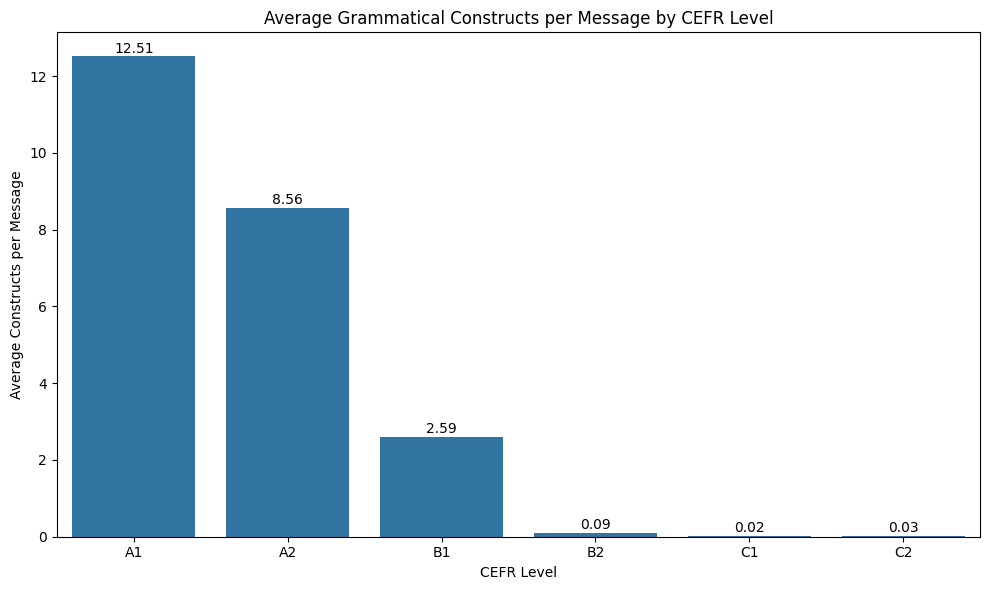

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

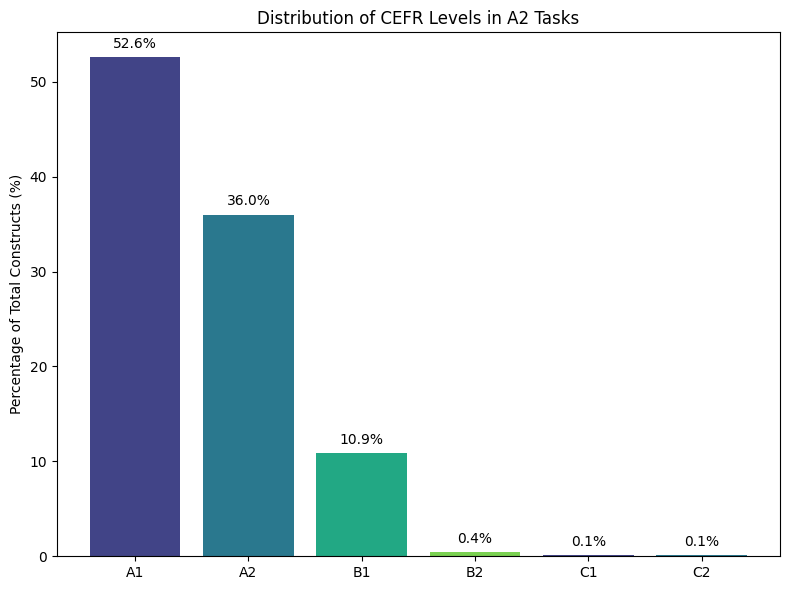

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

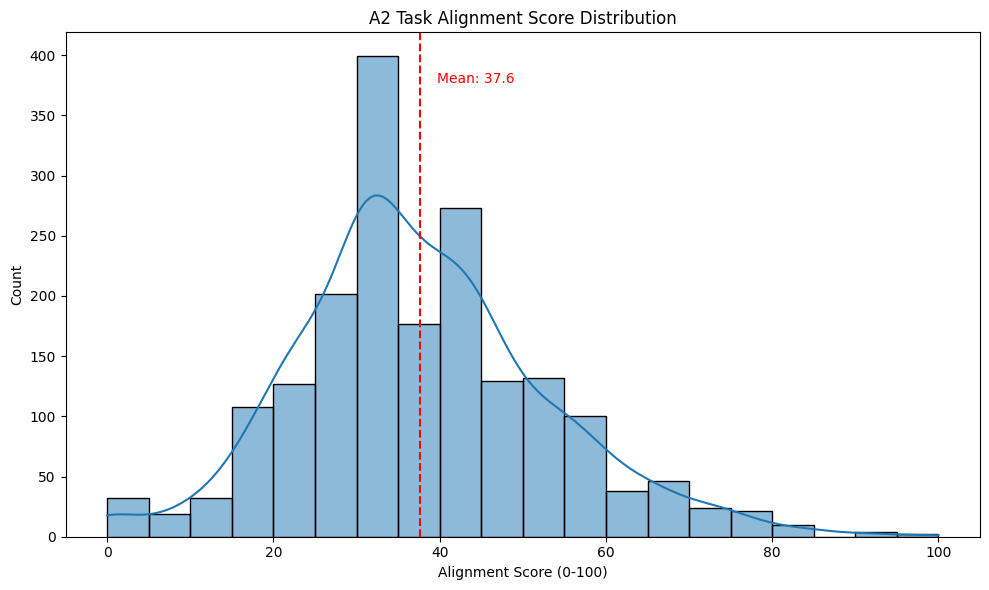

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

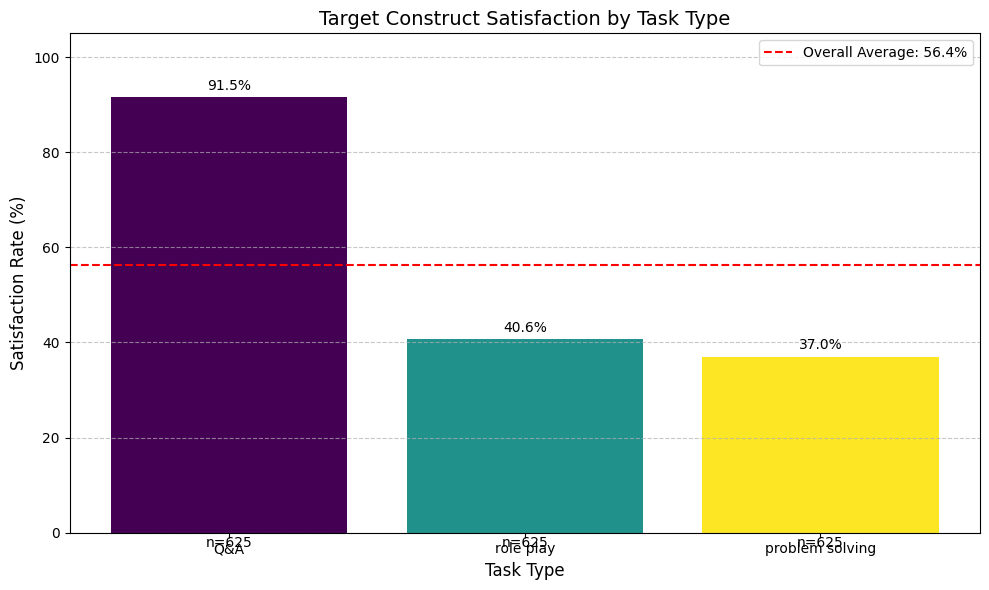

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

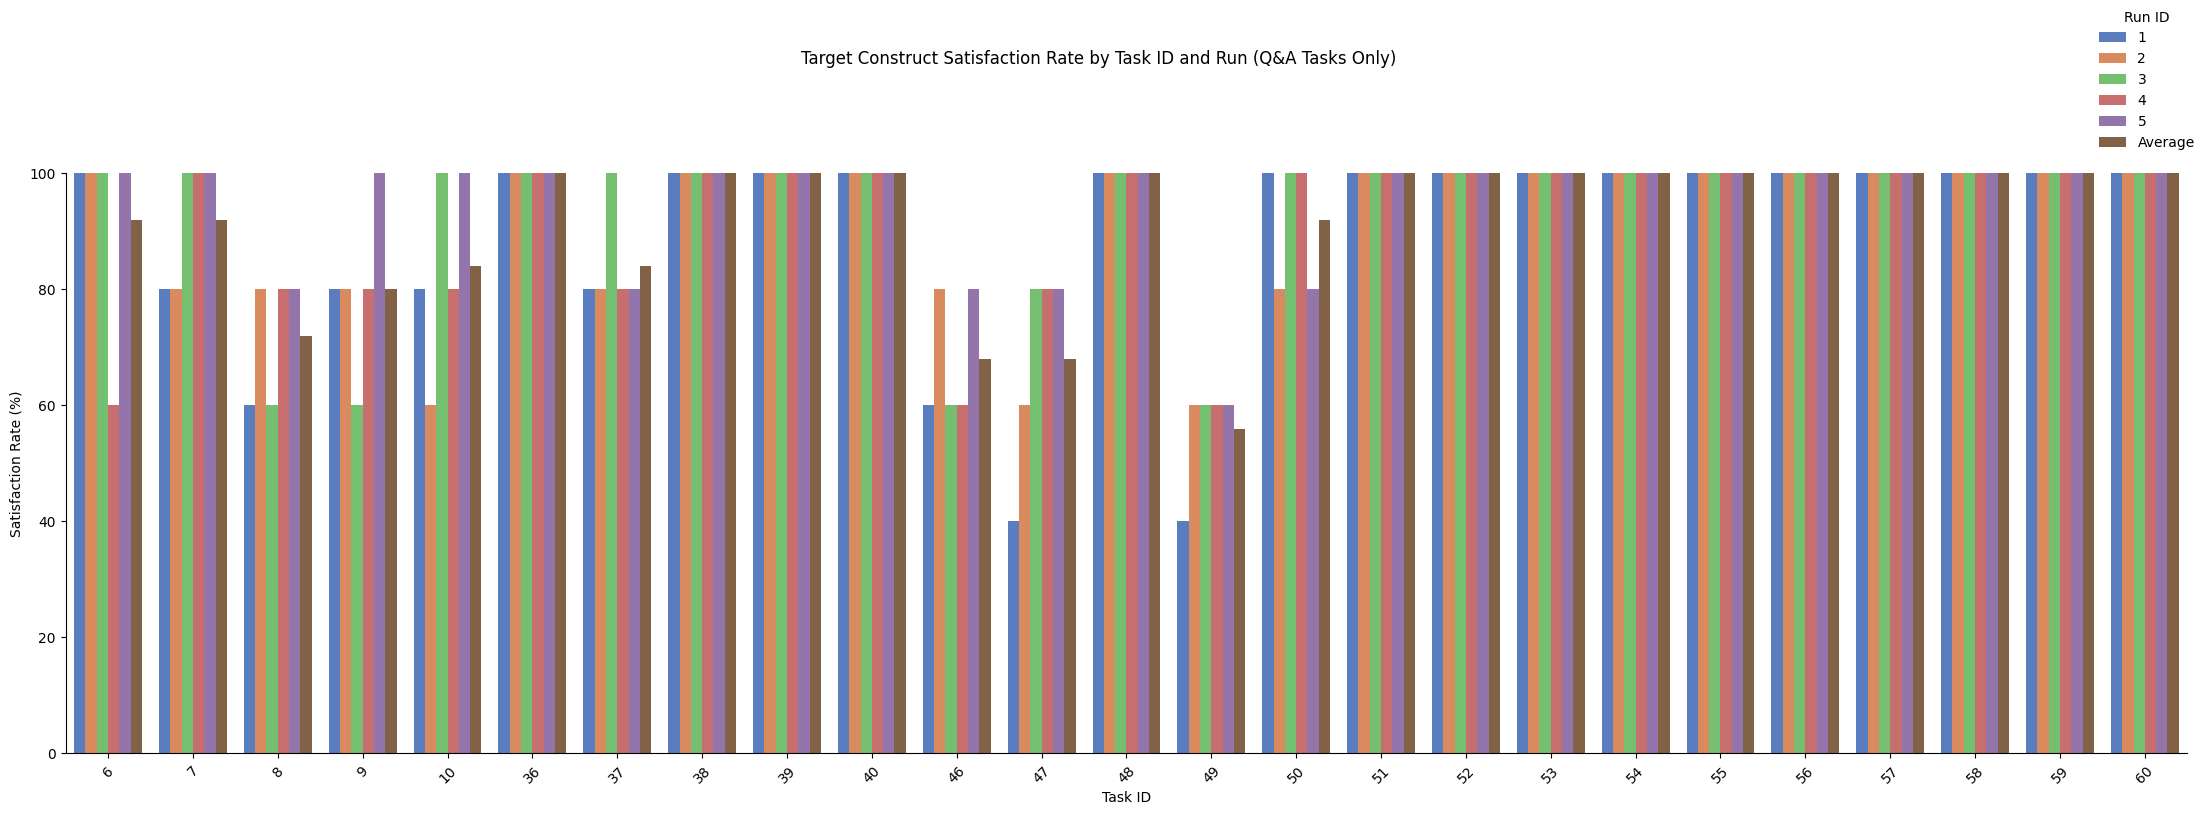

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## Deepseek V3 Results - with validation (temp=0)

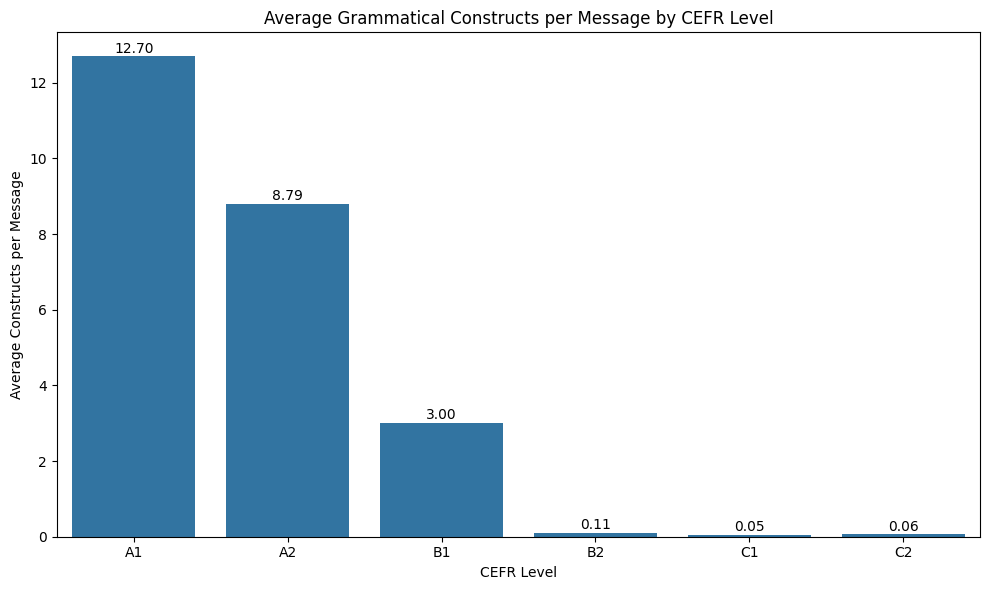

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

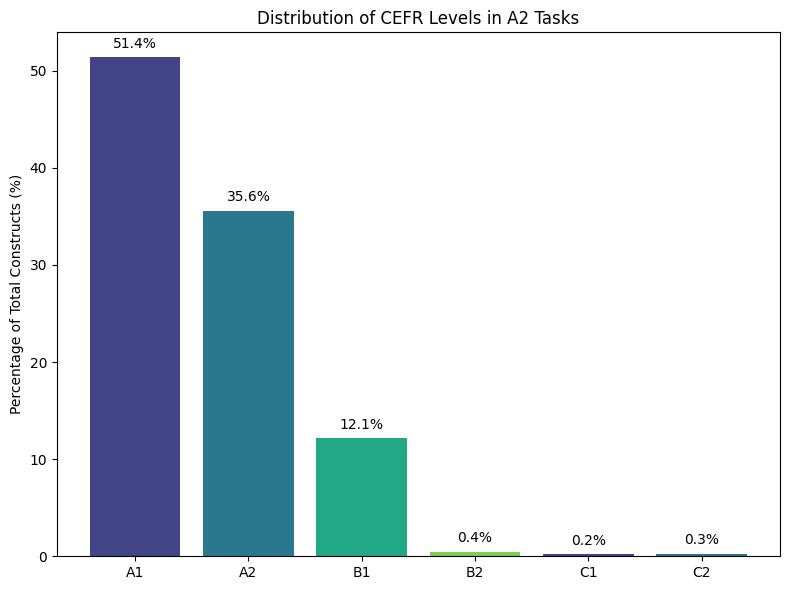

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

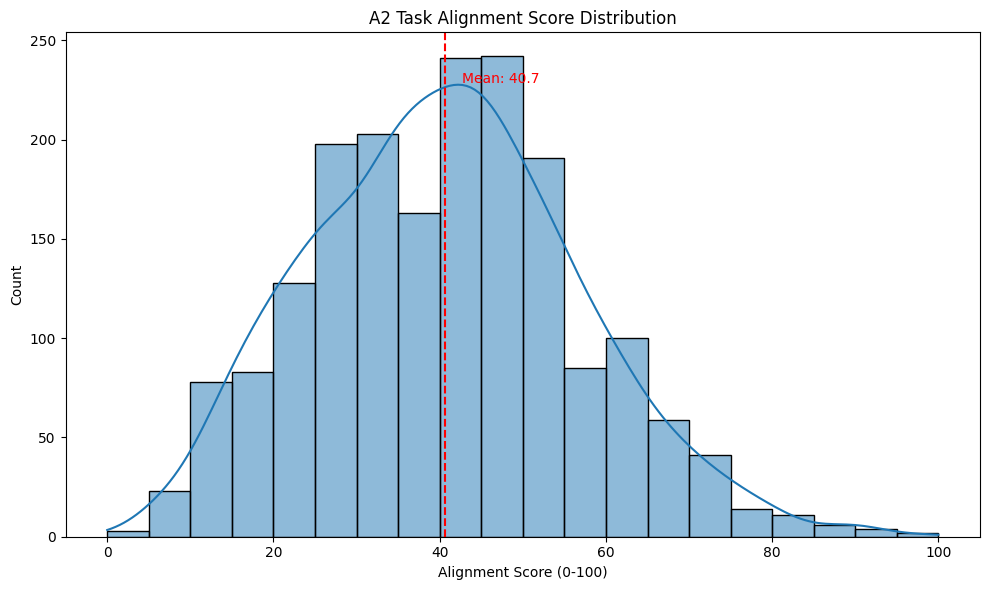

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

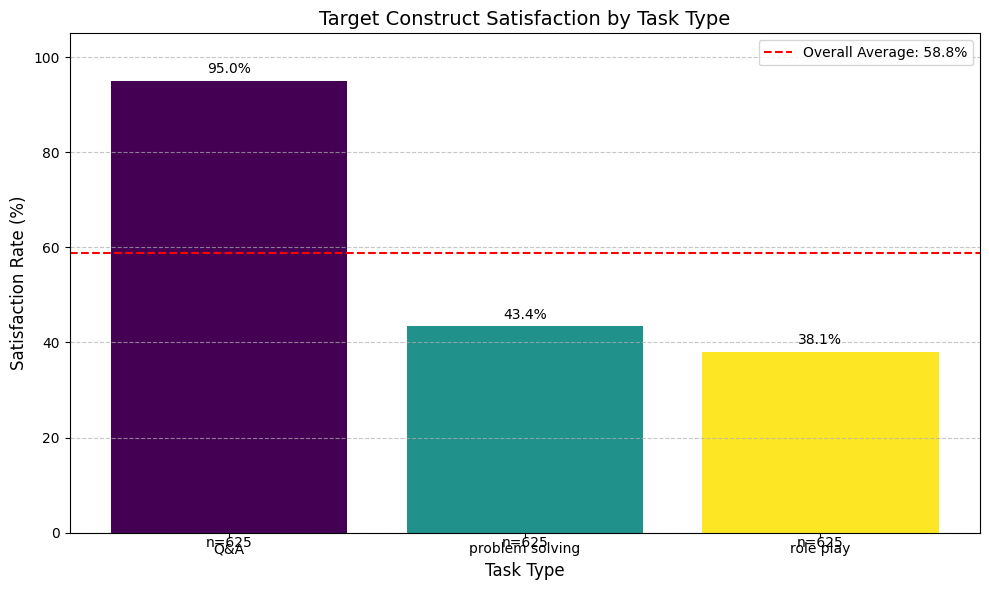

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

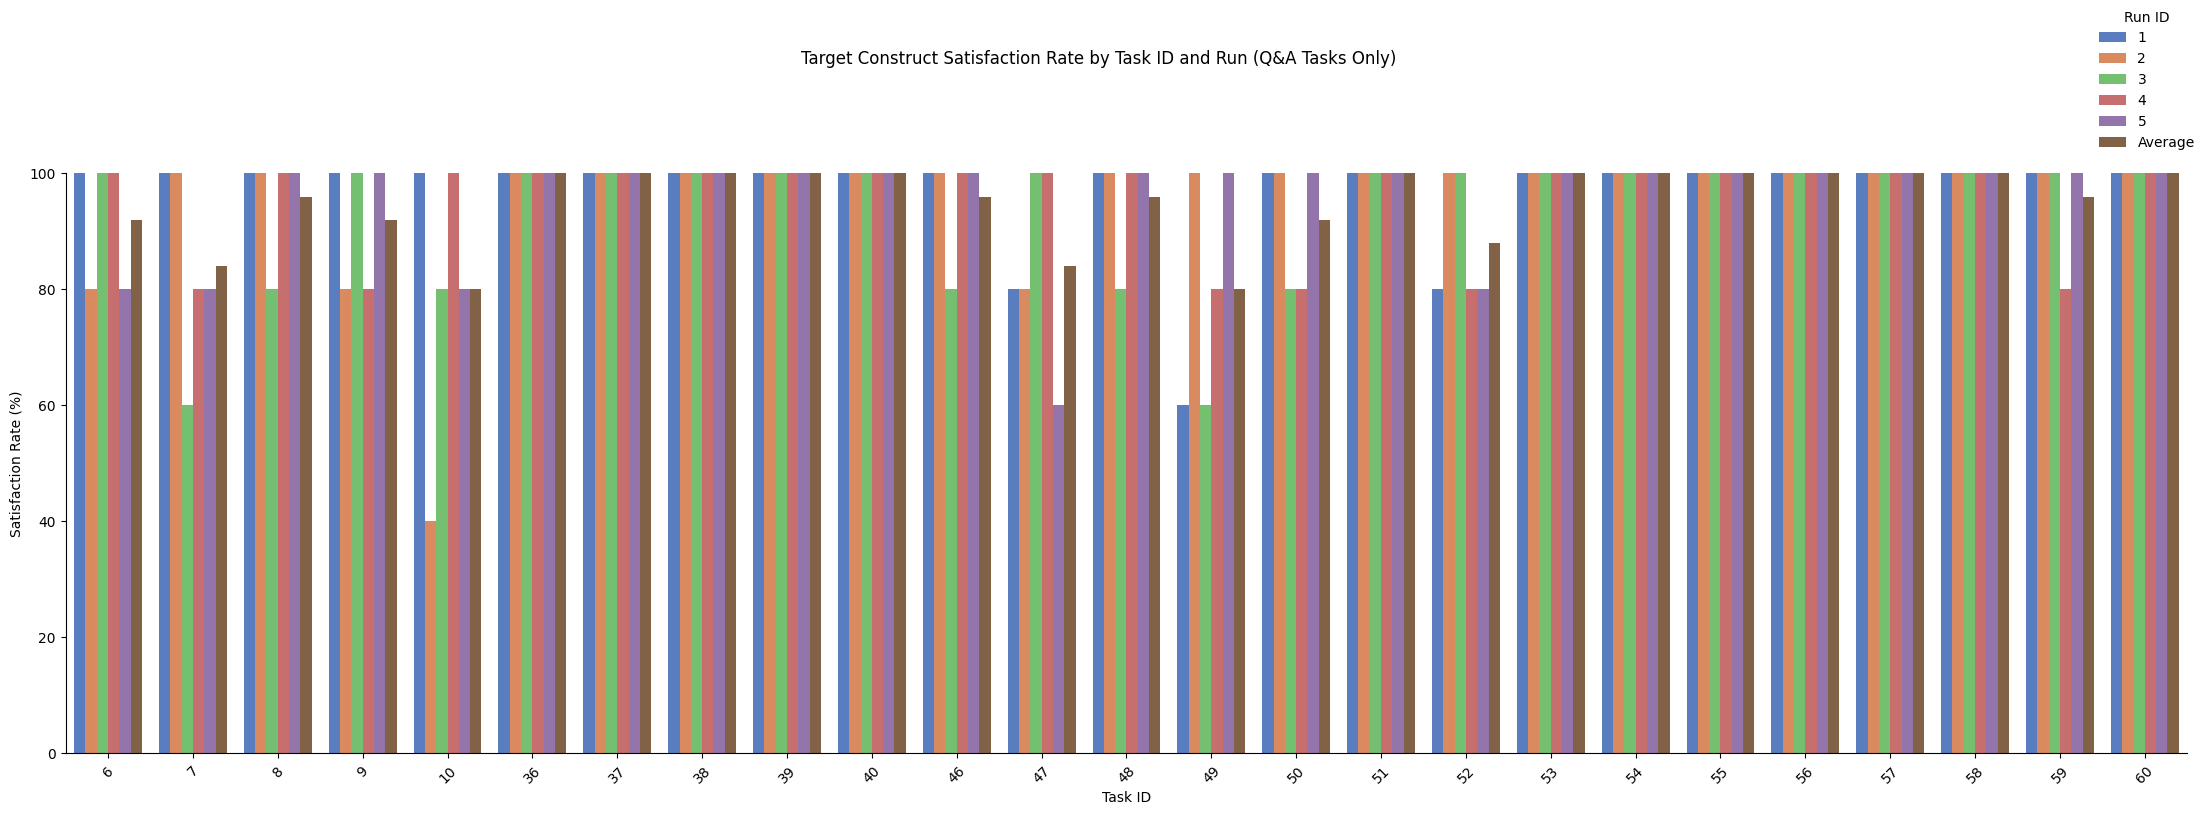

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## LLaMa 70B Results - with validation (temp=0)

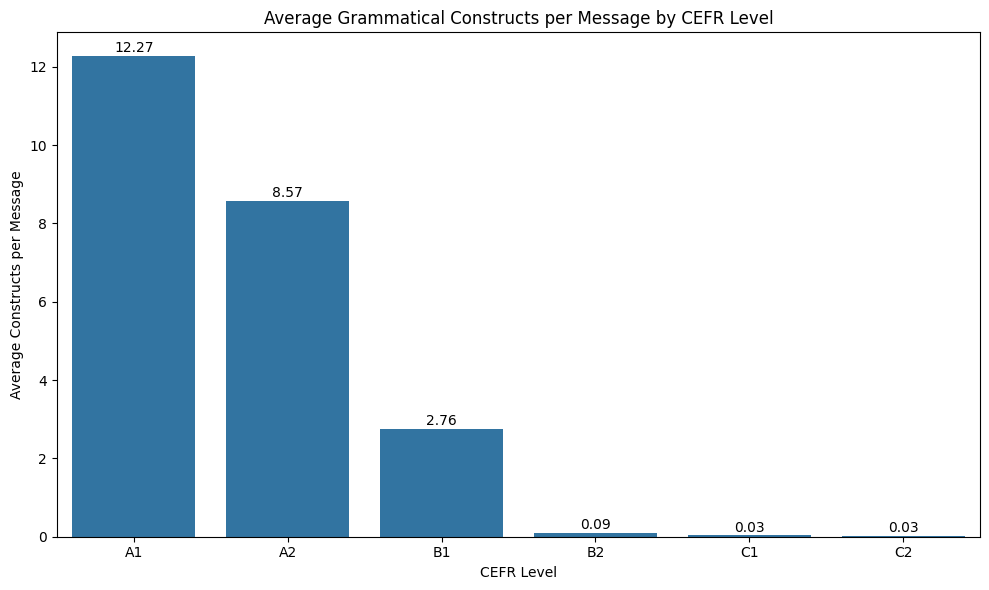

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

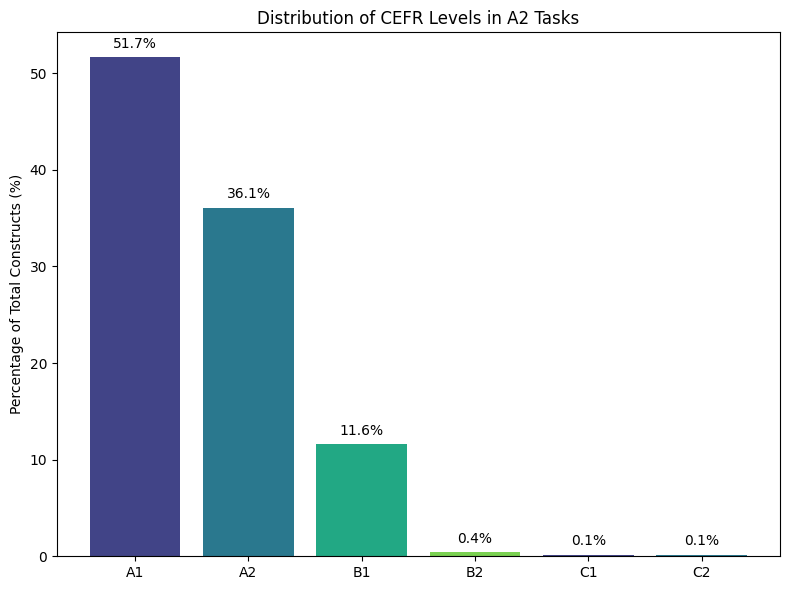

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

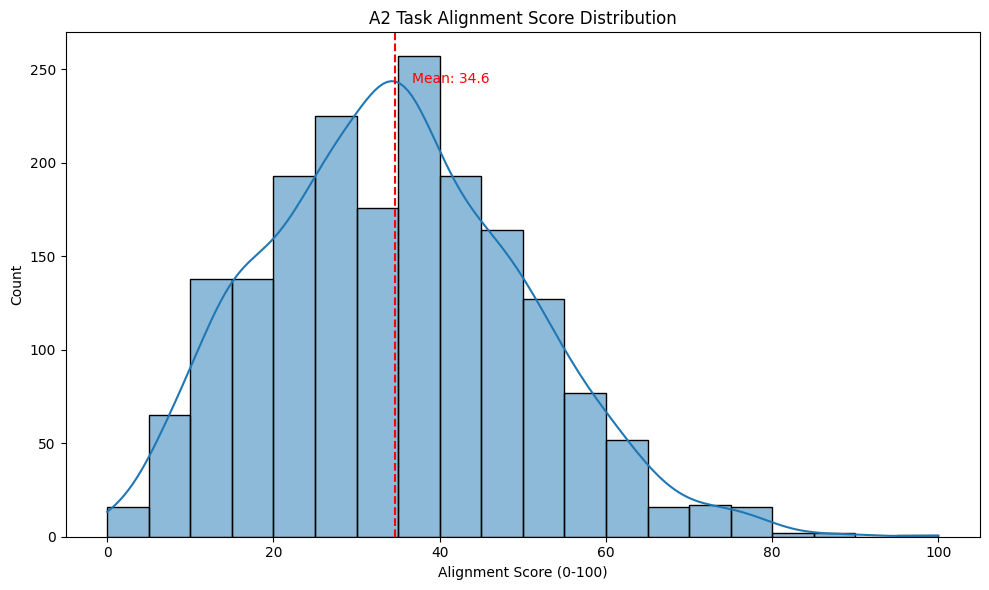

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

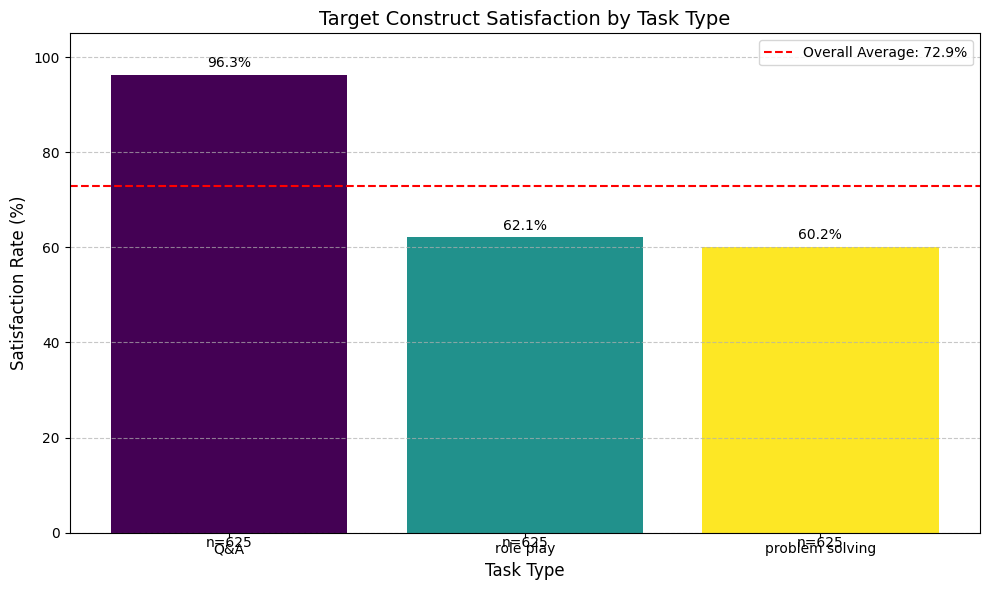

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

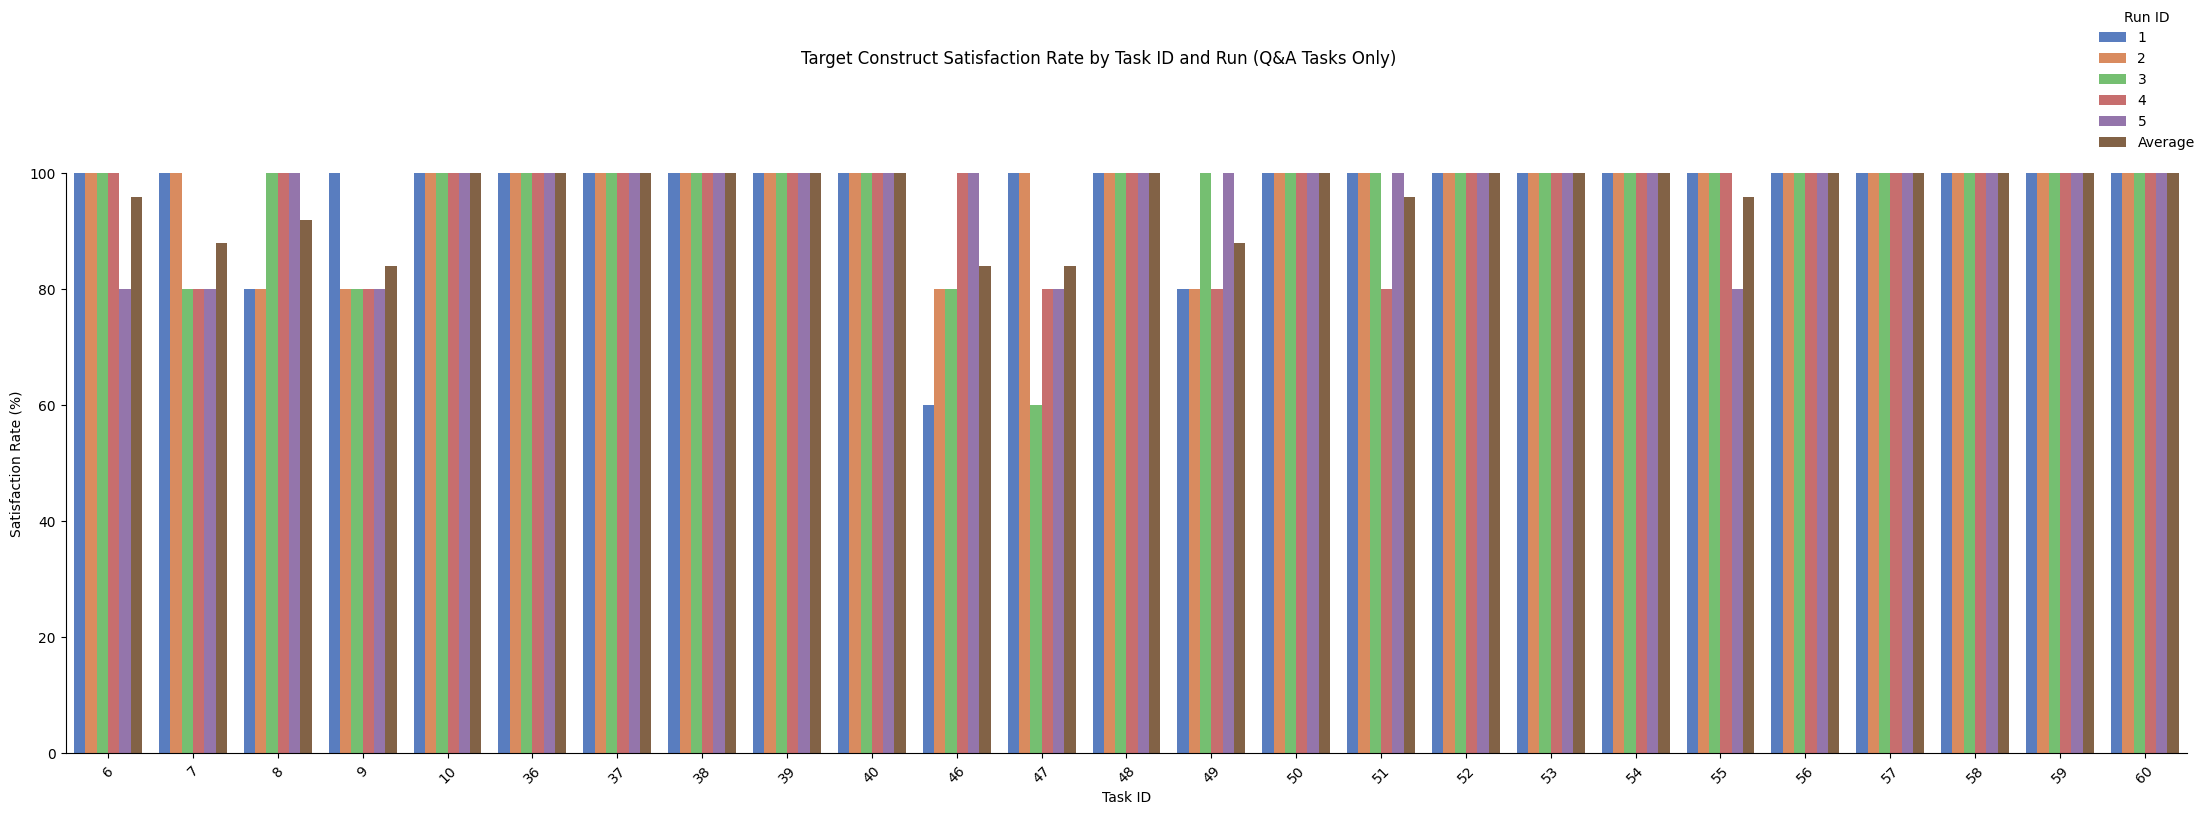

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## LLaMa 70B Results - with validation (temp=0)

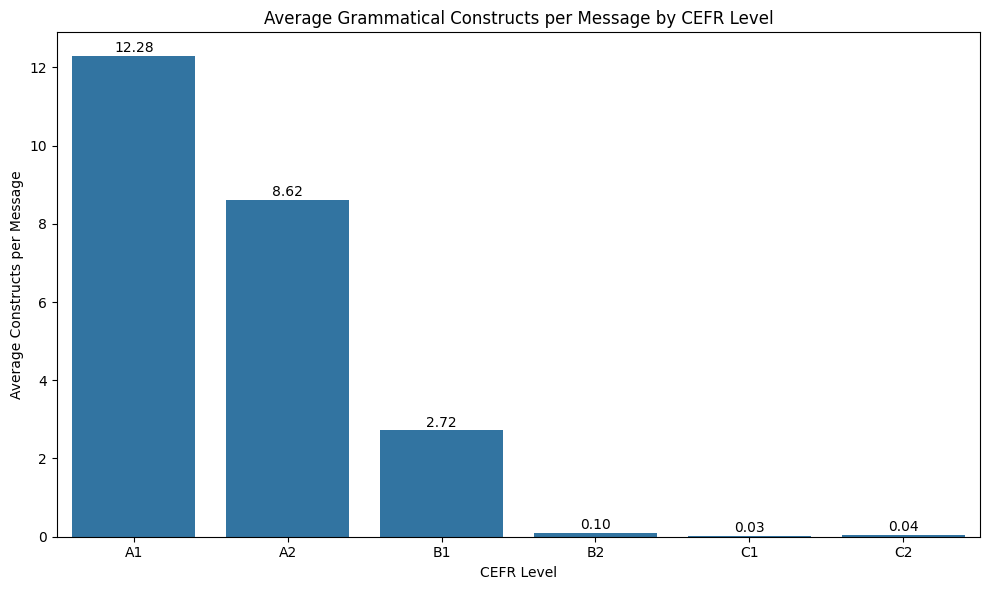

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

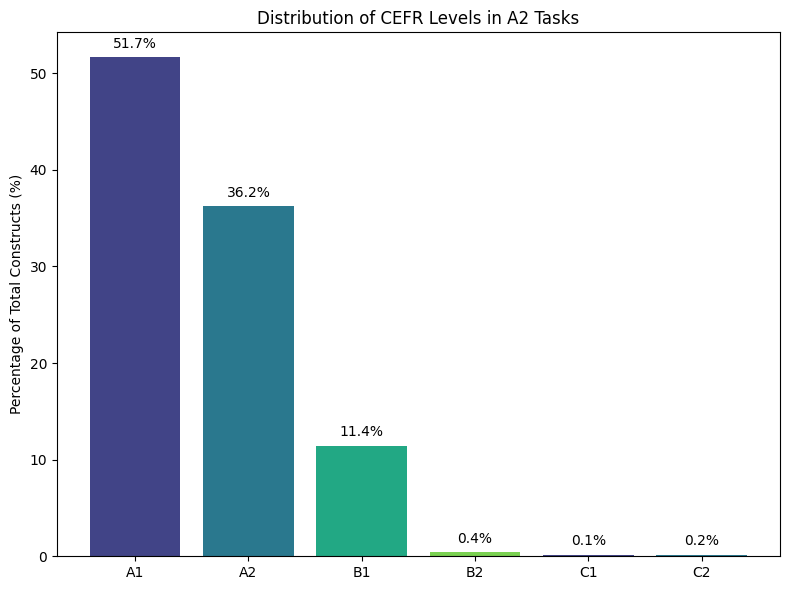

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

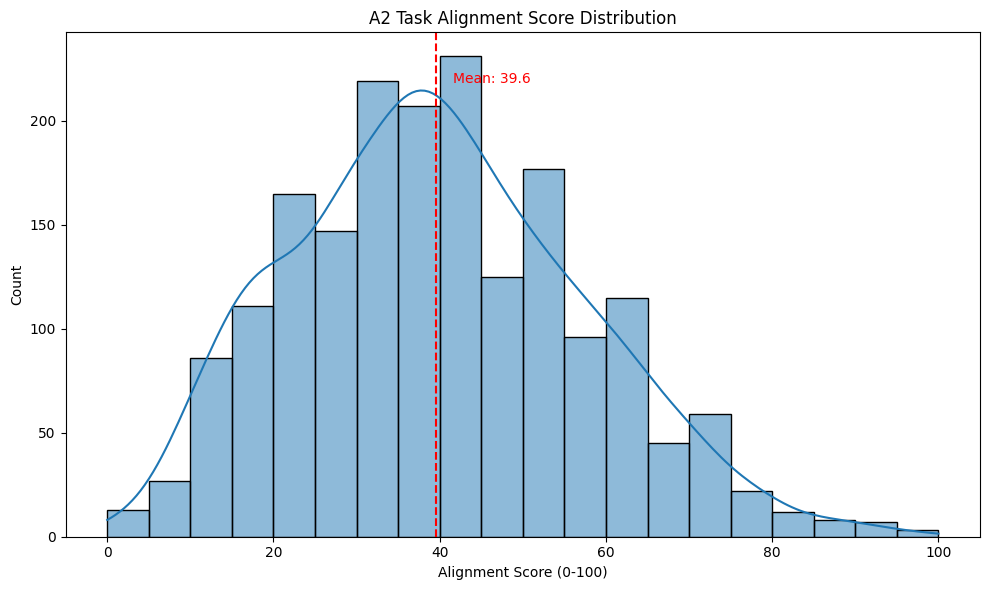

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

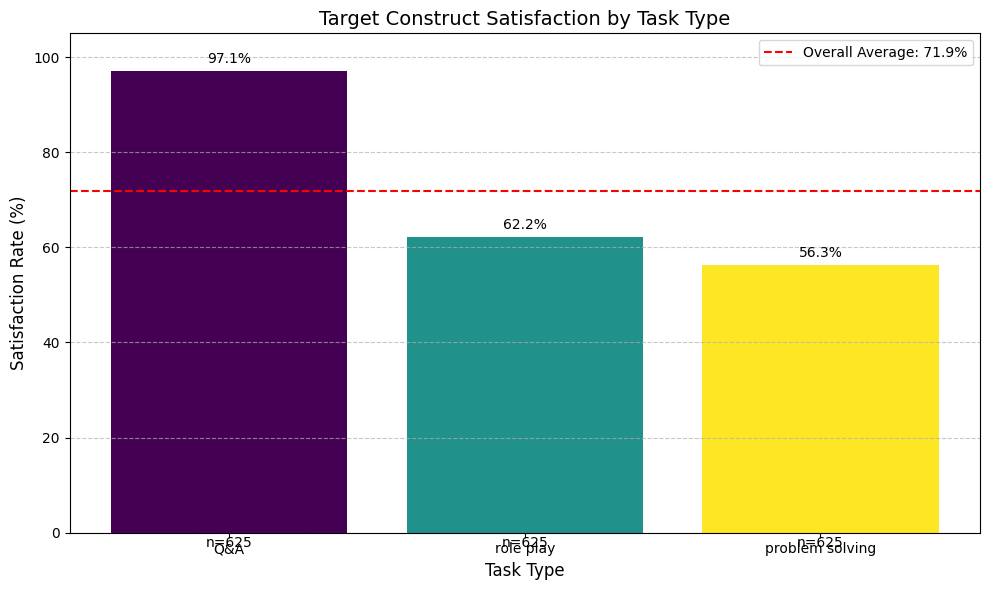

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

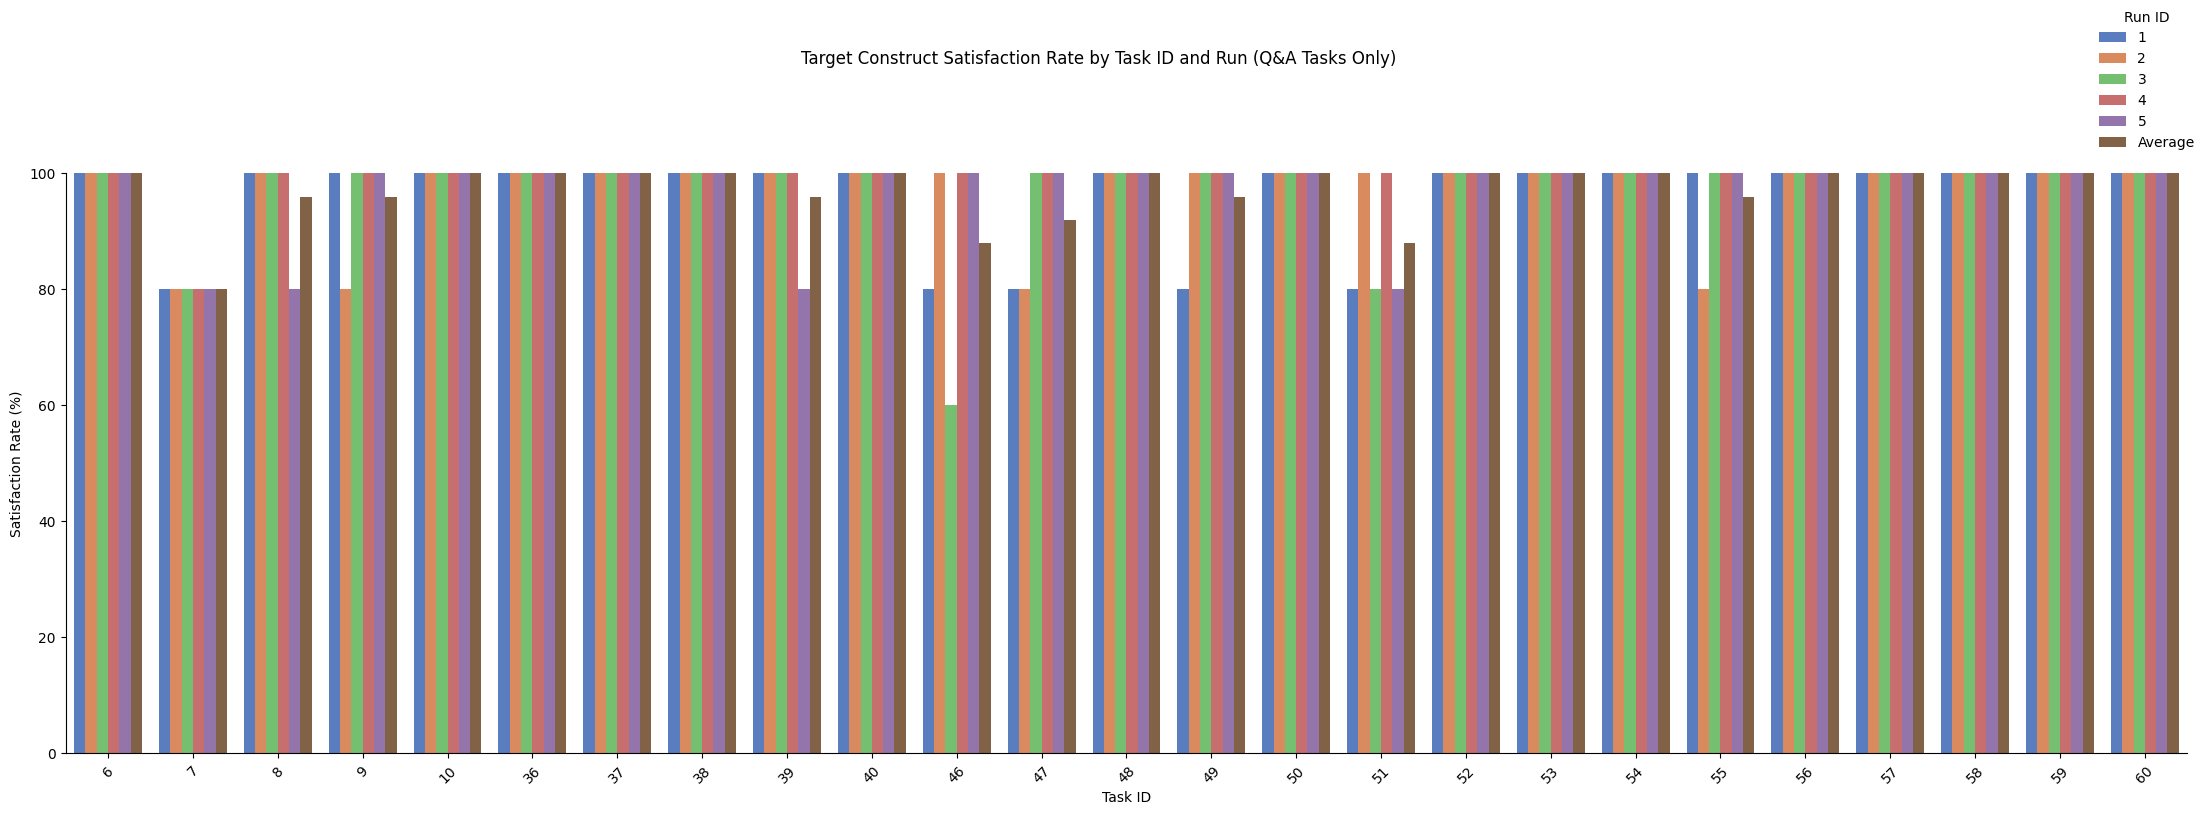

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

# Without validation

## GPT-4o Results (temp=0)

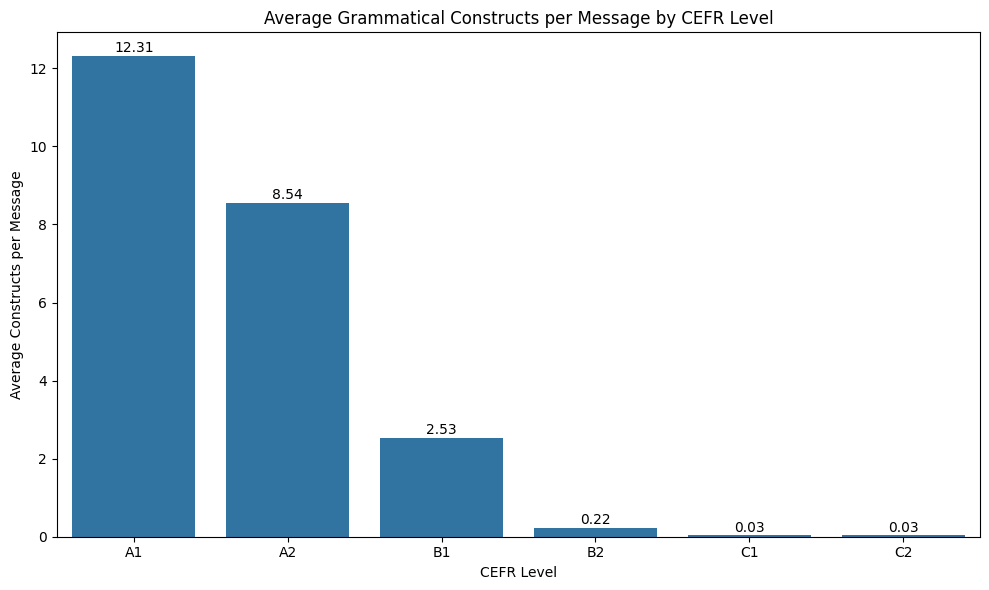

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

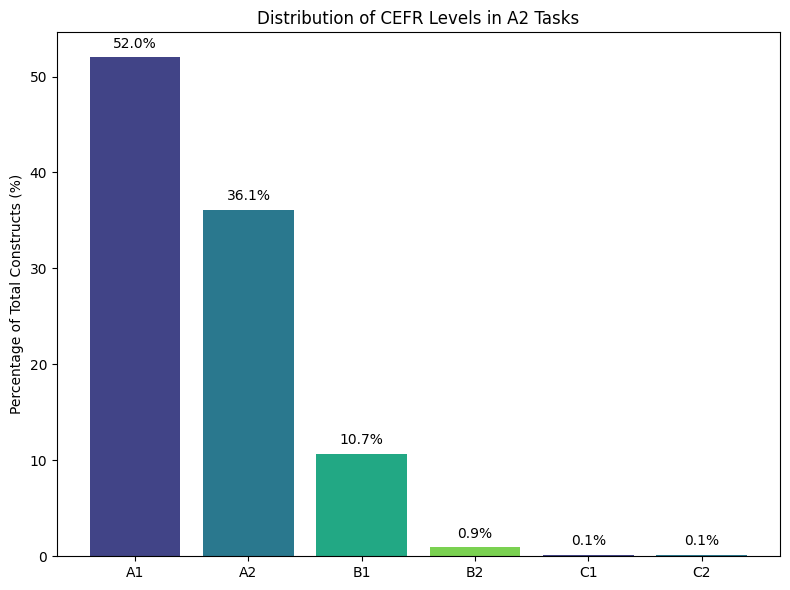

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

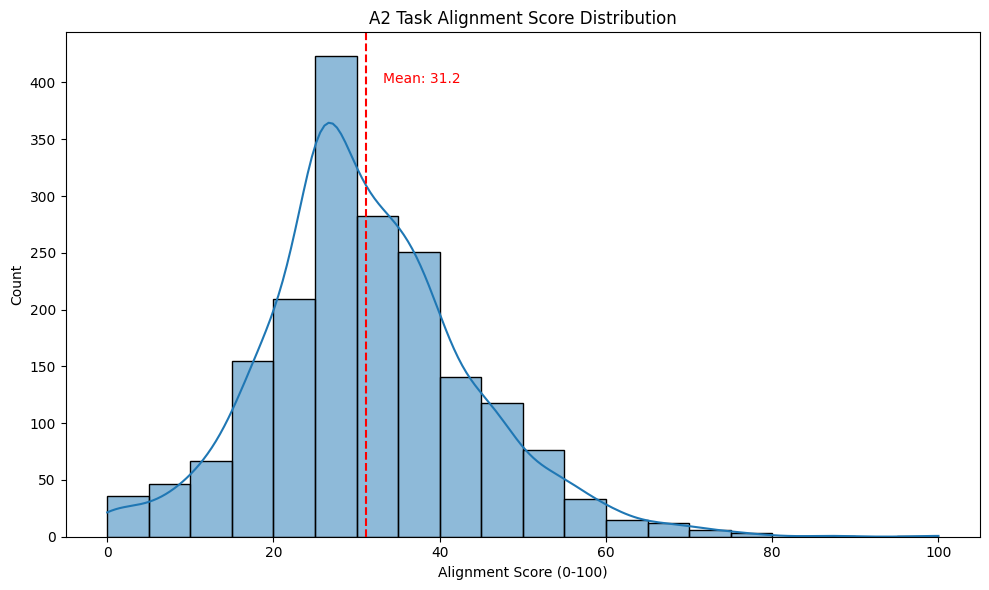

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

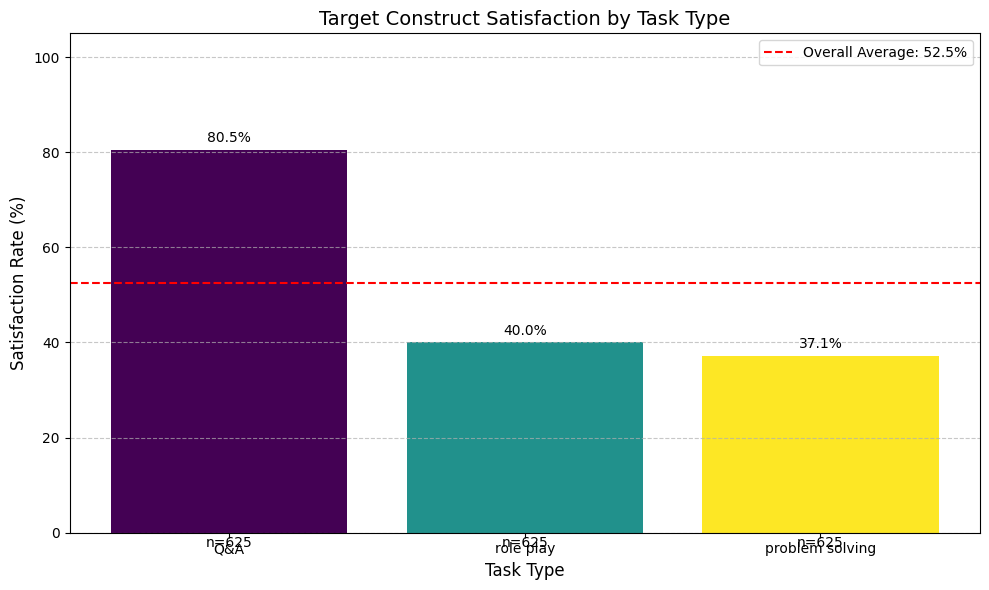

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

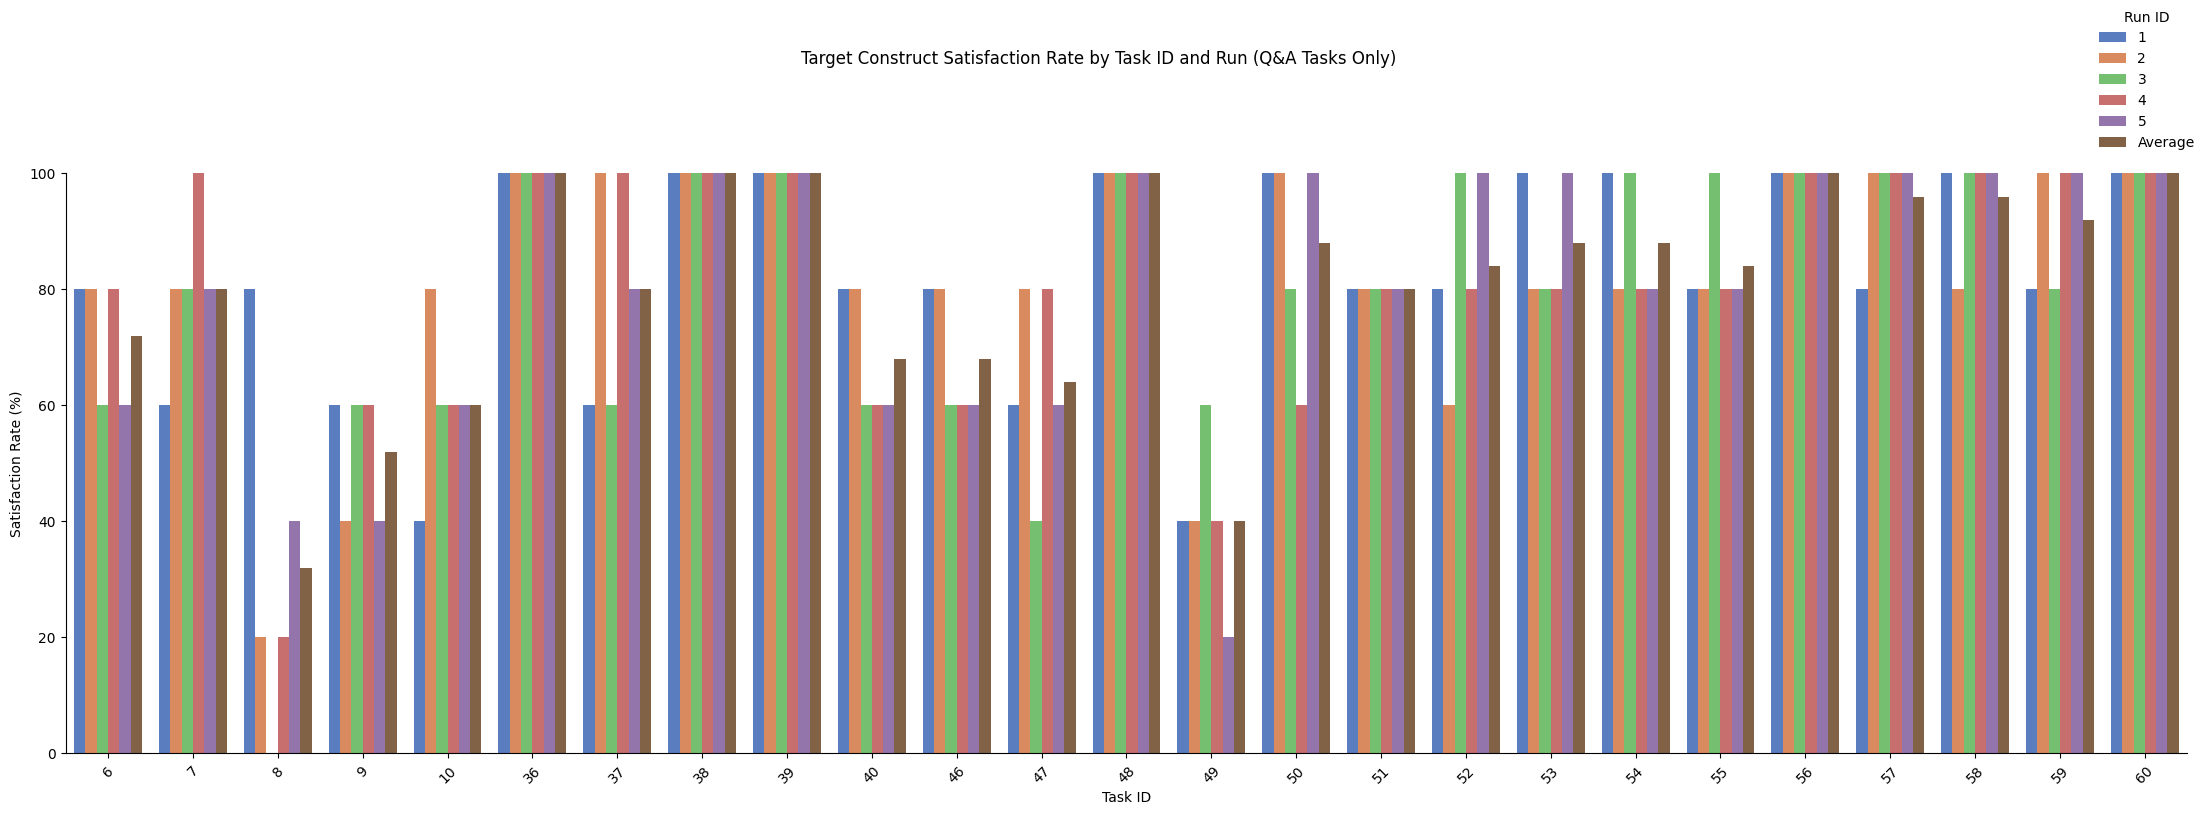

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## Deepseek V3 Results (temp=0)

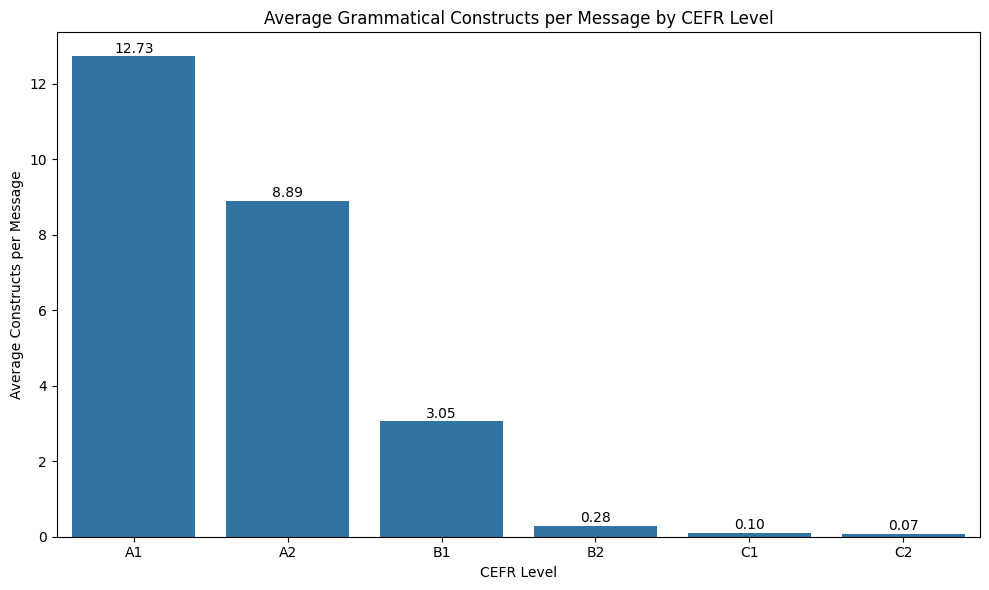

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

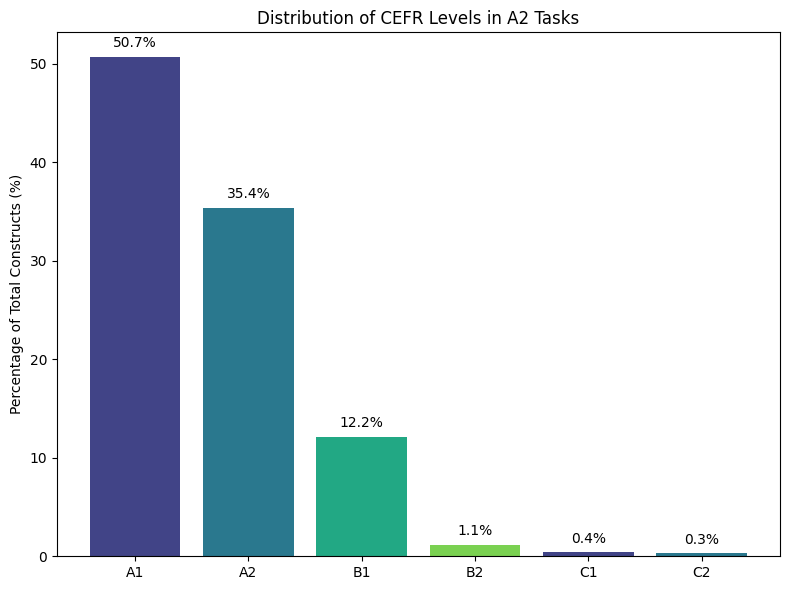

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

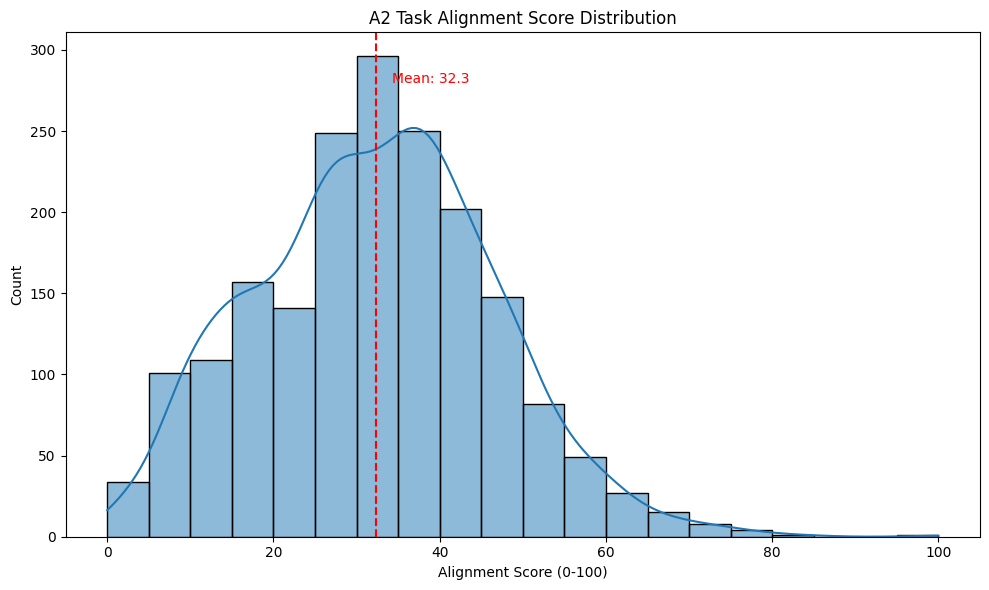

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

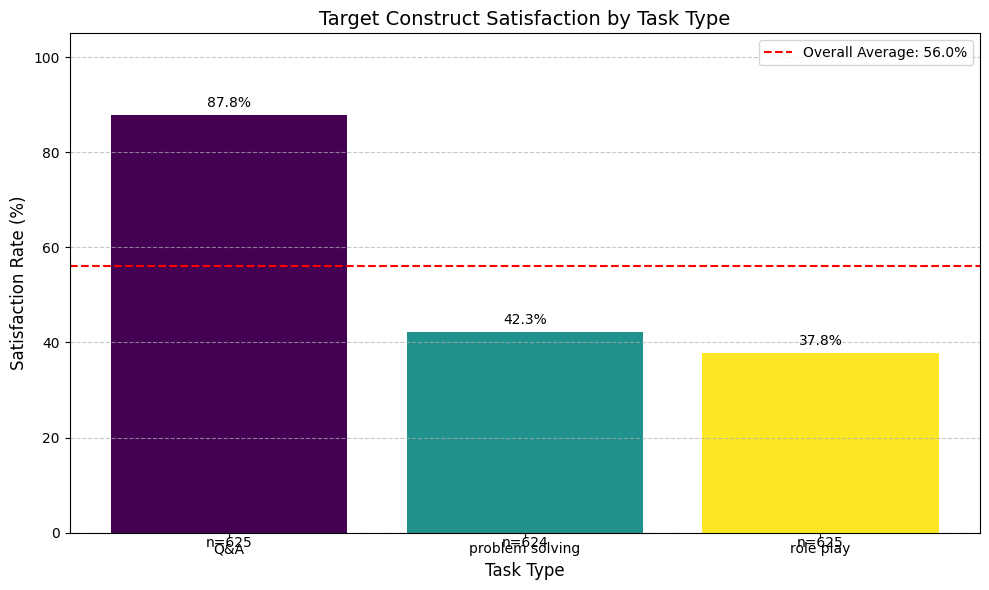

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

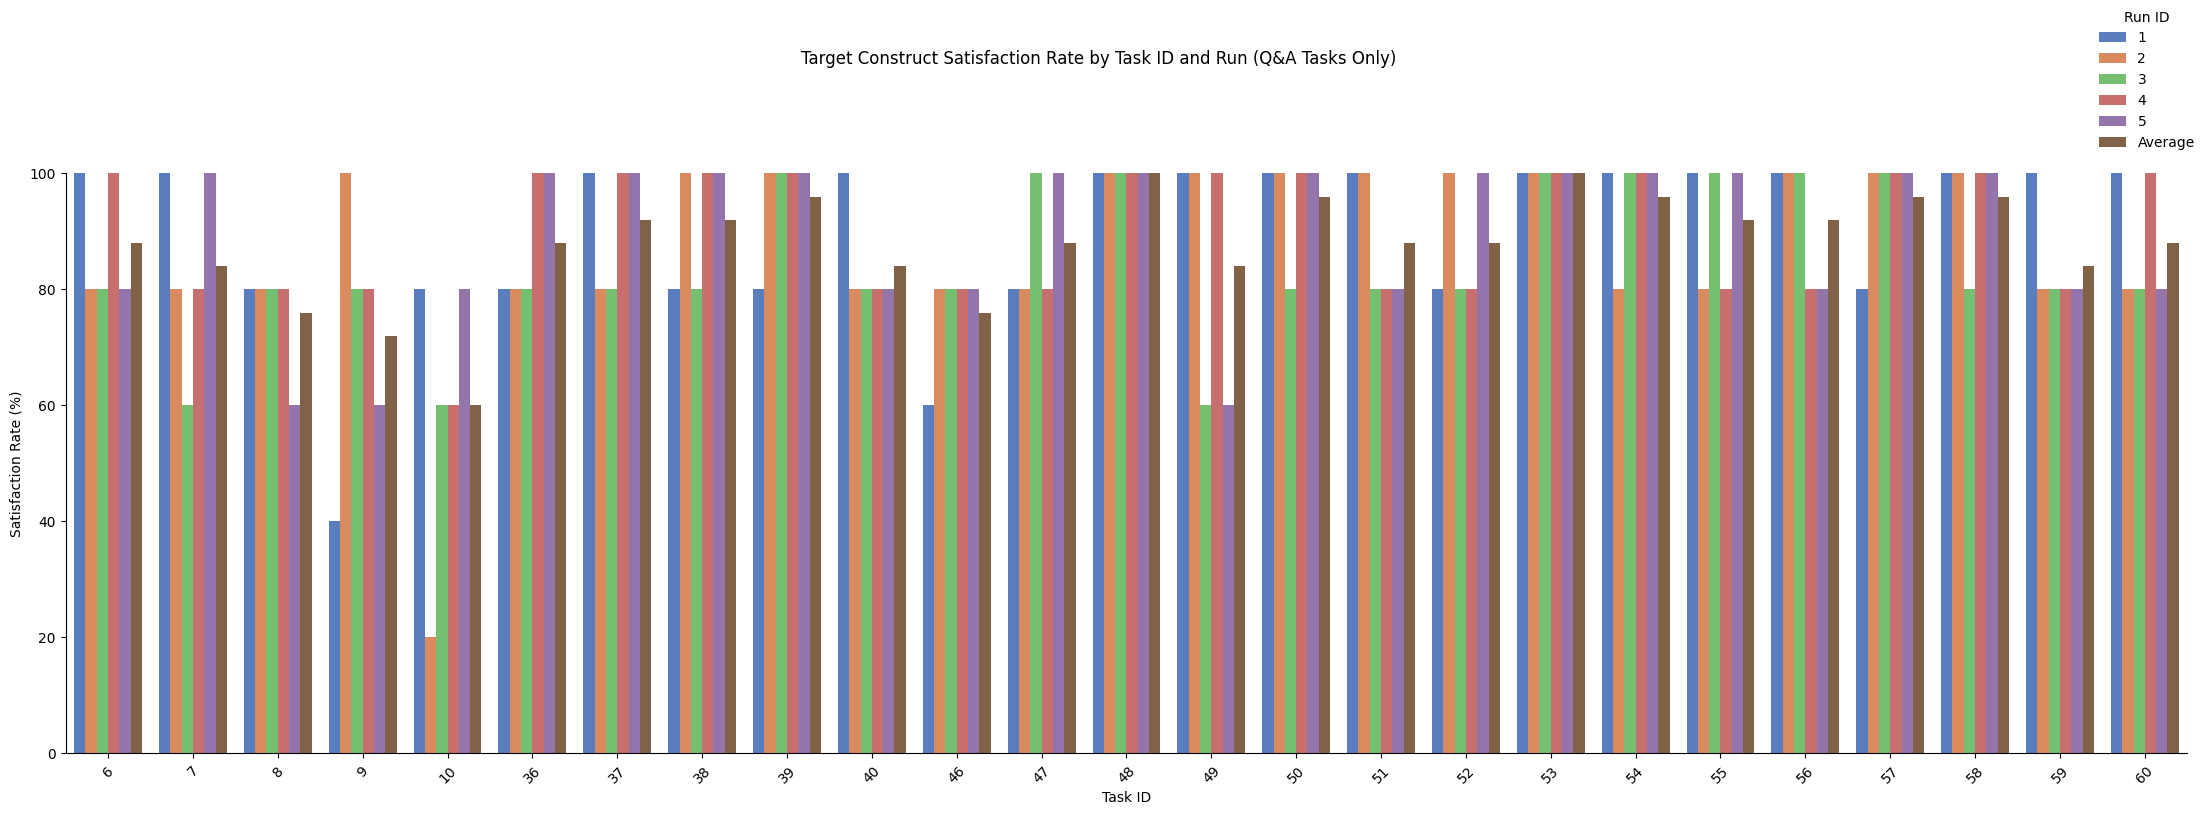

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## LLaMa 70B Results (temp=0)

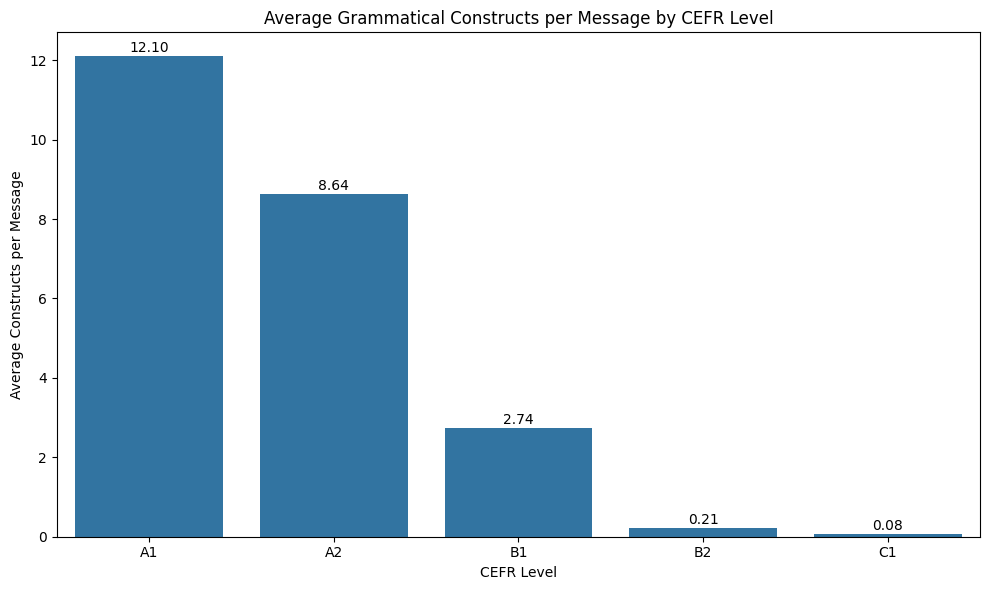

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

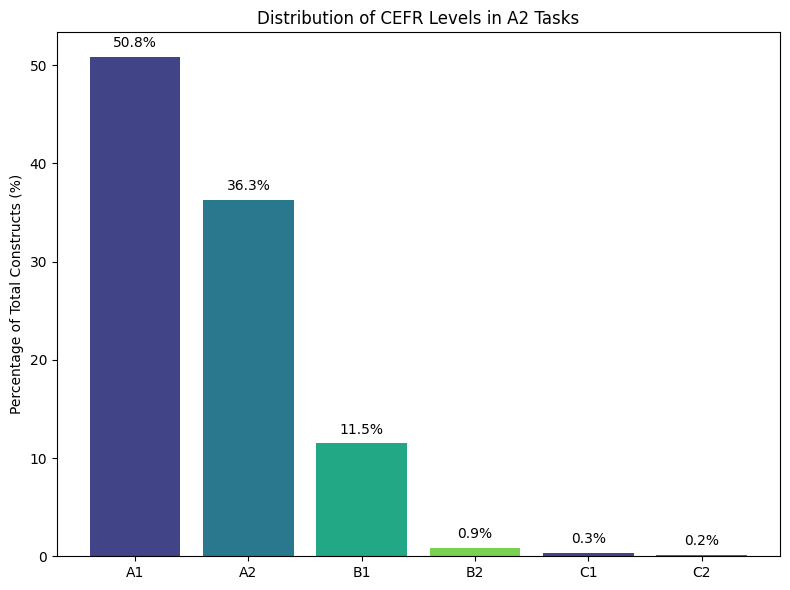

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

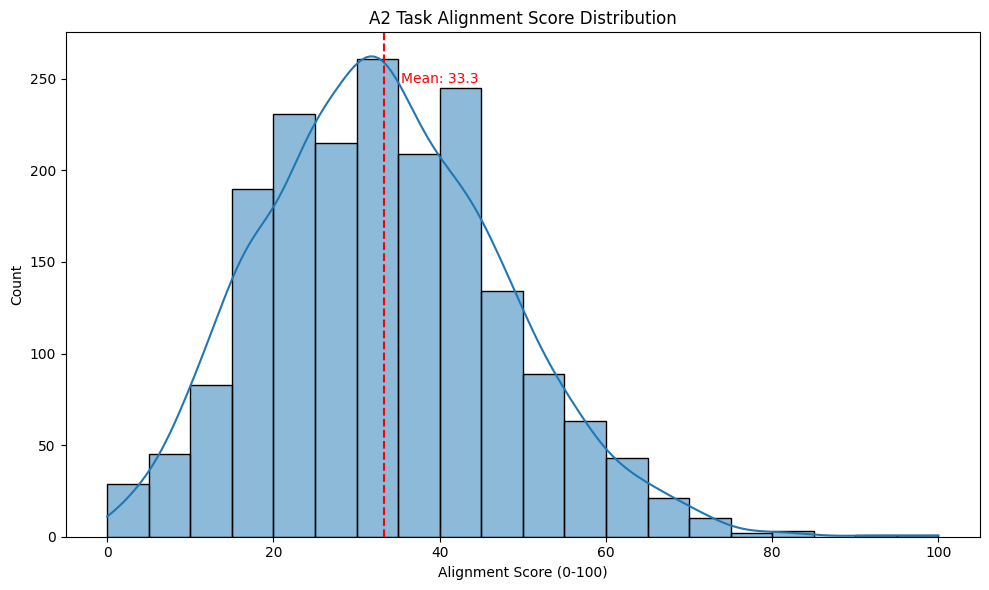

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

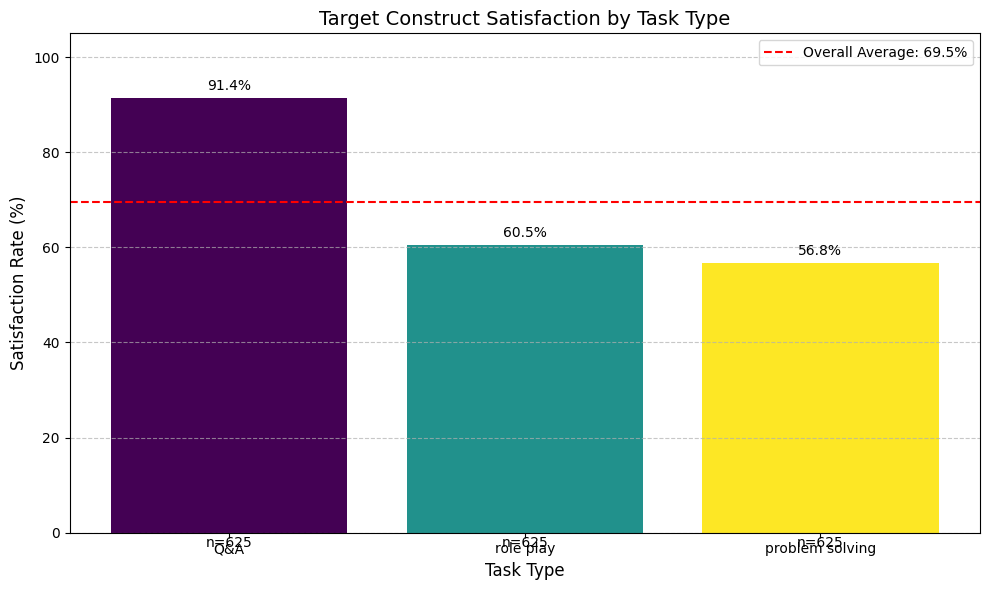

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

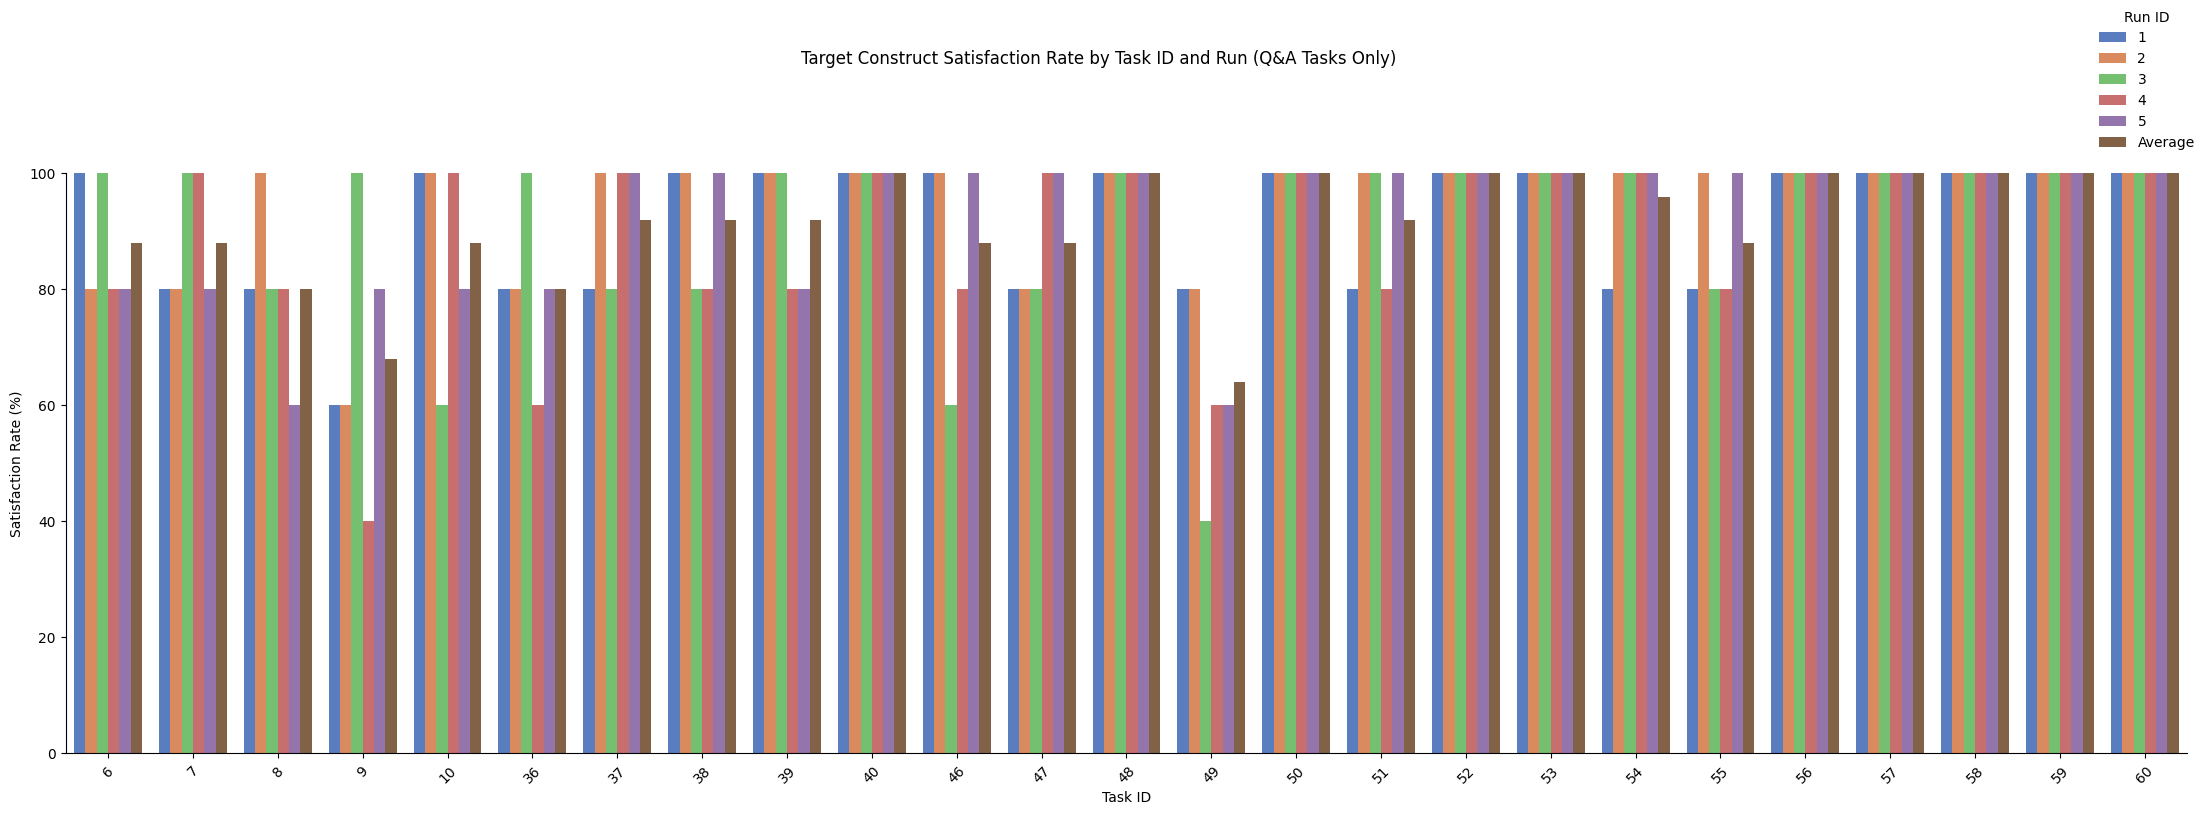

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## Mistral 24B Results (temp=0)

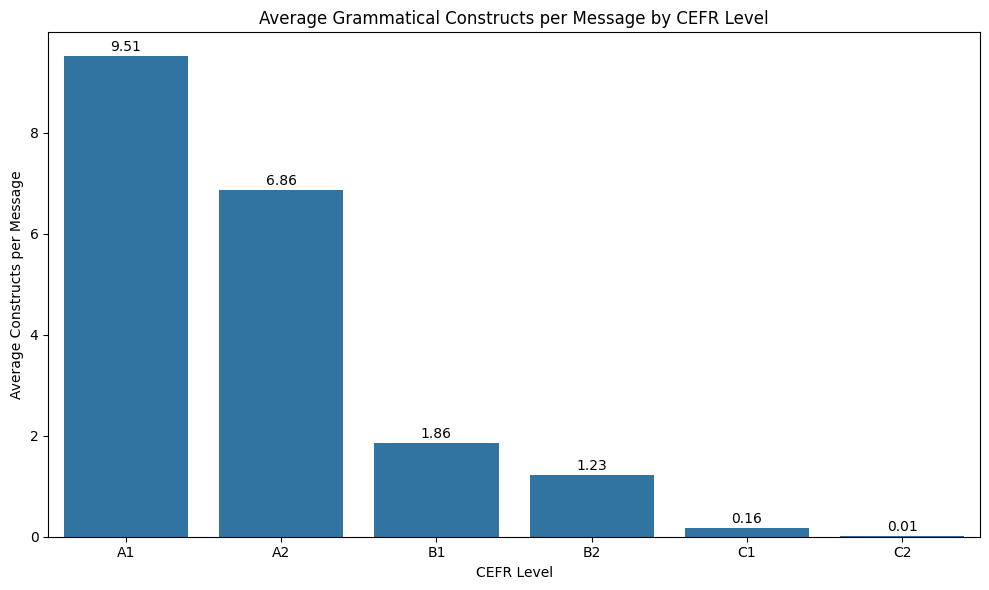

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

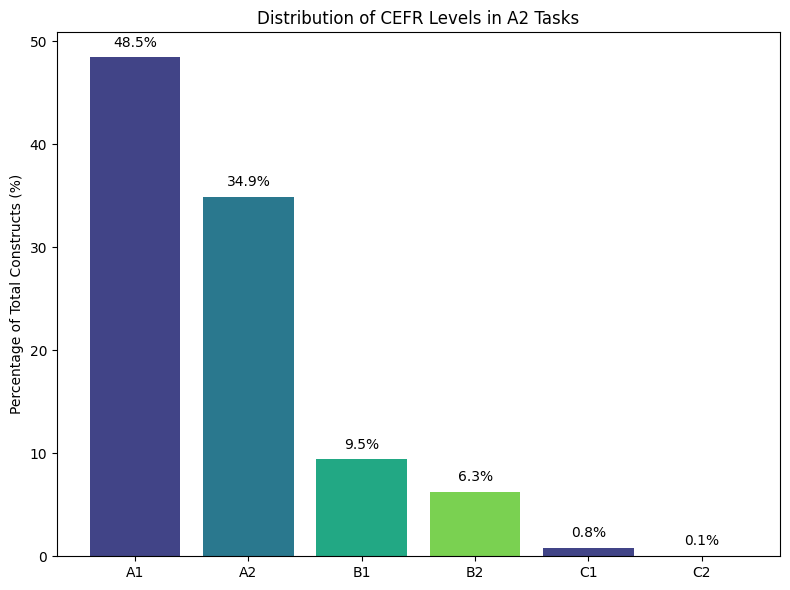

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

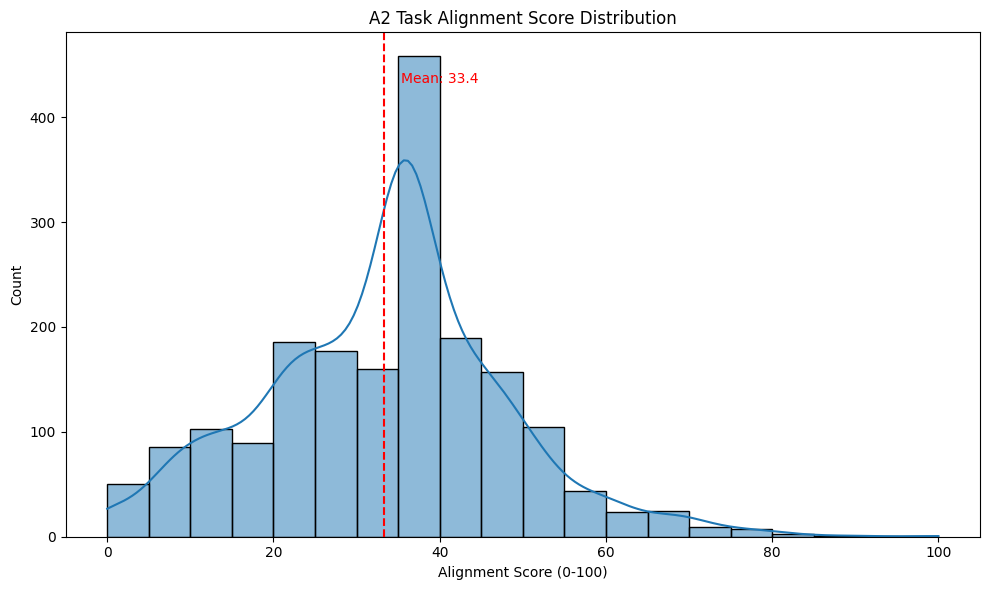

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

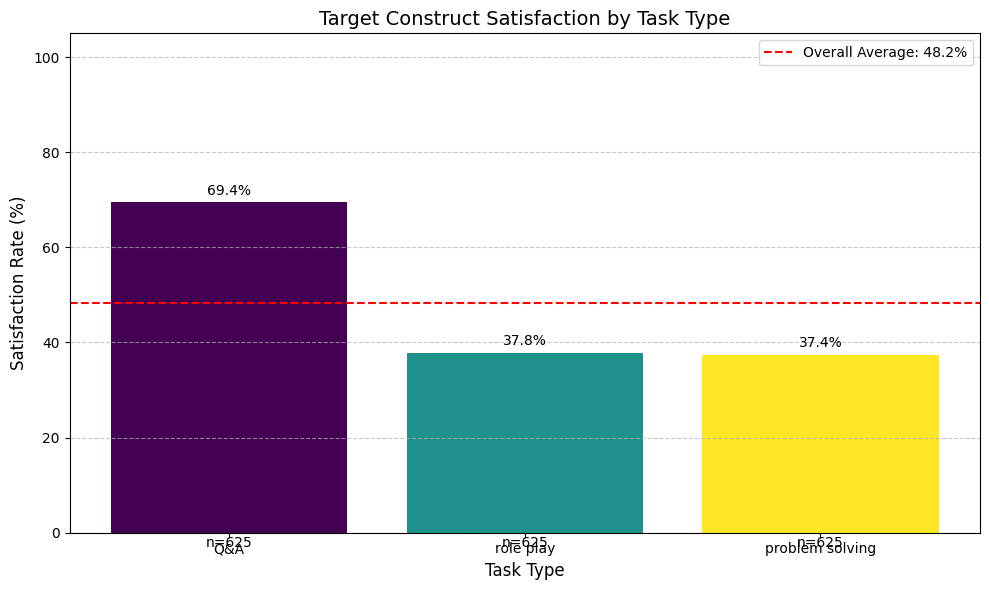

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

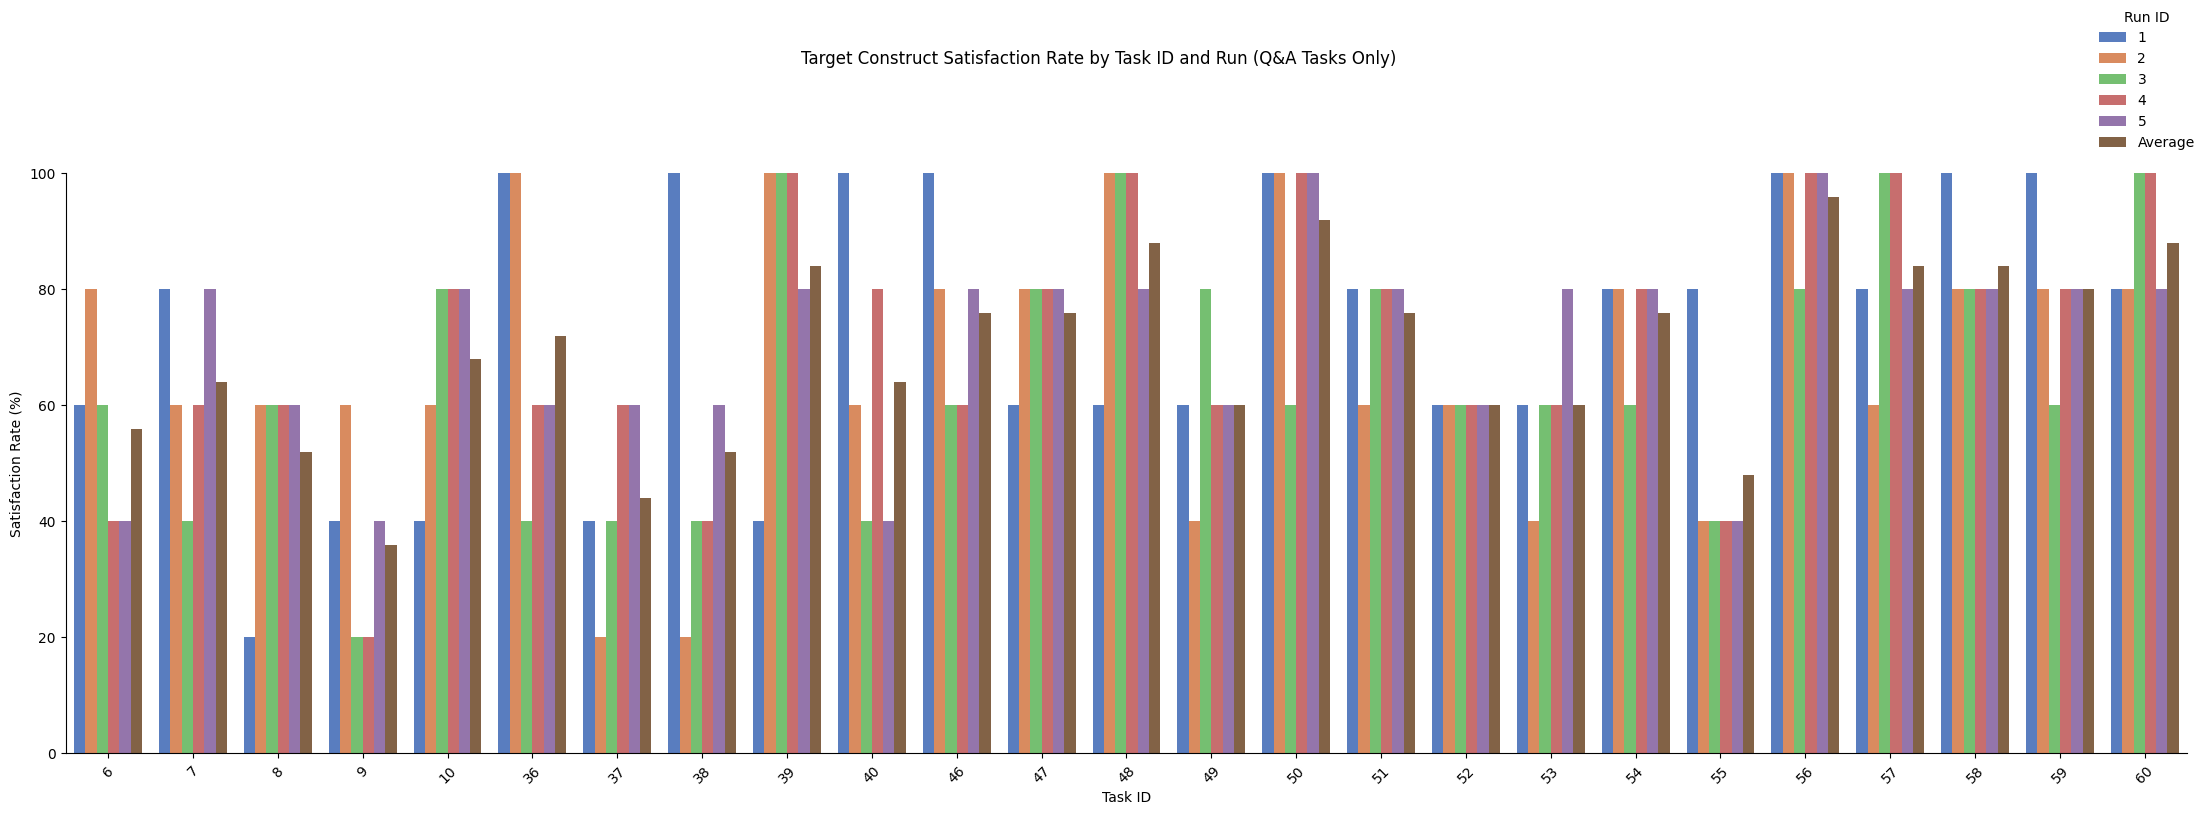

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()

## LLaMa 8B Results (temp=0)

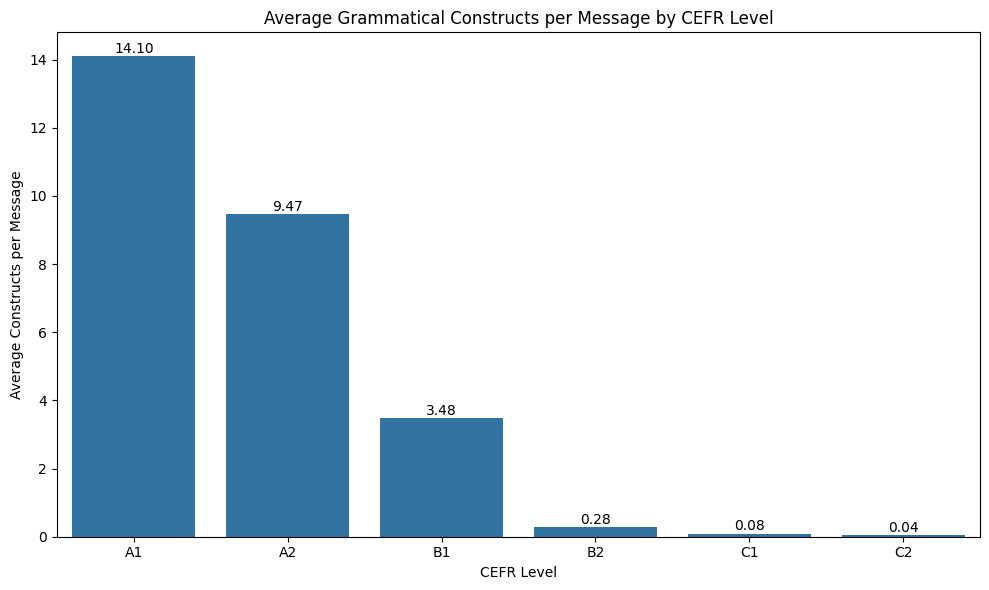

In [ ]:
# Calculate average constructs per proficiency level
level_averages = {
    "A1": analysis_df['a1_construct_count'].mean(),
    "A2": analysis_df['a2_construct_count'].mean(),
    "B1": analysis_df['b1_construct_count'].mean(),
    "B2": analysis_df['b2_construct_count'].mean(),
    "C1": analysis_df['c1_construct_count'].mean(),
    "C2": analysis_df['c2_construct_count'].mean()
}

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(level_averages.keys()), y=list(level_averages.values()))
plt.title('Average Grammatical Constructs per Message by CEFR Level')
plt.ylabel('Average Constructs per Message')
plt.xlabel('CEFR Level')

# Add value labels on top of bars
for i, v in enumerate(level_averages.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('proficiency_distribution.png')
plt.show()

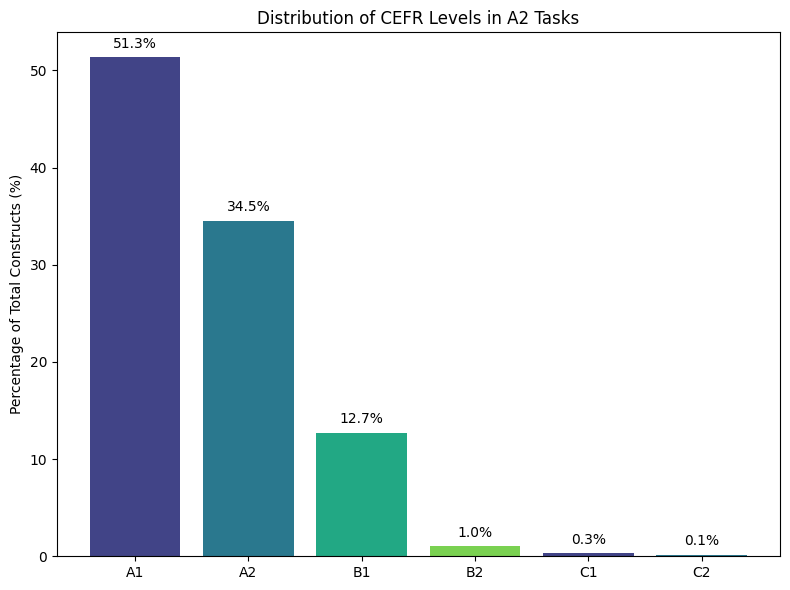

In [ ]:
# Calculate total constructs at each level
total_constructs = {
    "A1": analysis_df['a1_construct_count'].sum(),
    "A2": analysis_df['a2_construct_count'].sum(),
    "B1": analysis_df['b1_construct_count'].sum(),
    "B2": analysis_df['b2_construct_count'].sum(),
    "C1": analysis_df['c1_construct_count'].sum(),
    "C2": analysis_df['c2_construct_count'].sum()
}

# Convert to percentages
total = sum(total_constructs.values())
percentages = {k: (v/total)*100 for k, v in total_constructs.items()}

# Create percentage chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(percentages)), list(percentages.values()), color=sns.color_palette("viridis", 4))
plt.xticks(range(len(percentages)), list(percentages.keys()))
plt.title('Distribution of CEFR Levels in A2 Tasks')
plt.ylabel('Percentage of Total Constructs (%)')

# Add percentage labels
for i, v in enumerate(percentages.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('level_percentages.png')
plt.show()

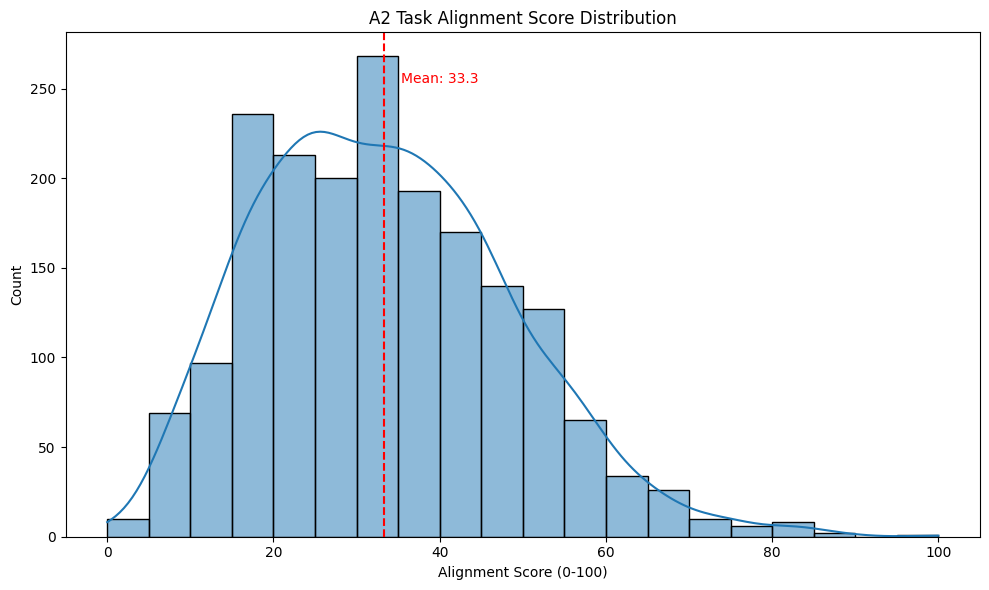

In [ ]:
# Create an alignment index where:
# - Higher A2 content increases the score
# - Higher B2/C1 content decreases the score
# - B1 is neutral (appropriate challenge)

analysis_df['alignment_index'] = (
    analysis_df['a2_construct_count'] * 2 +
    analysis_df['b1_construct_count'] * 1 -
    analysis_df['b2_construct_count'] * 1 -
    analysis_df['c1_construct_count'] * 2
)

# Normalize to 0-100 scale
min_val = analysis_df['alignment_index'].min()
max_val = analysis_df['alignment_index'].max()
analysis_df['alignment_score'] = 100 * (analysis_df['alignment_index'] - min_val) / (max_val - min_val)

# Create histogram of alignment scores
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['alignment_score'], bins=20, kde=True)
plt.axvline(x=analysis_df['alignment_score'].mean(), color='r', linestyle='--')
plt.title('A2 Task Alignment Score Distribution')
plt.xlabel('Alignment Score (0-100)')
plt.ylabel('Count')

# Add mean label
plt.text(
    analysis_df['alignment_score'].mean() + 2,
    plt.ylim()[1] * 0.9,
    f"Mean: {analysis_df['alignment_score'].mean():.1f}",
    color='r'
)

plt.tight_layout()
plt.savefig('alignment_score_distribution.png')
plt.show()

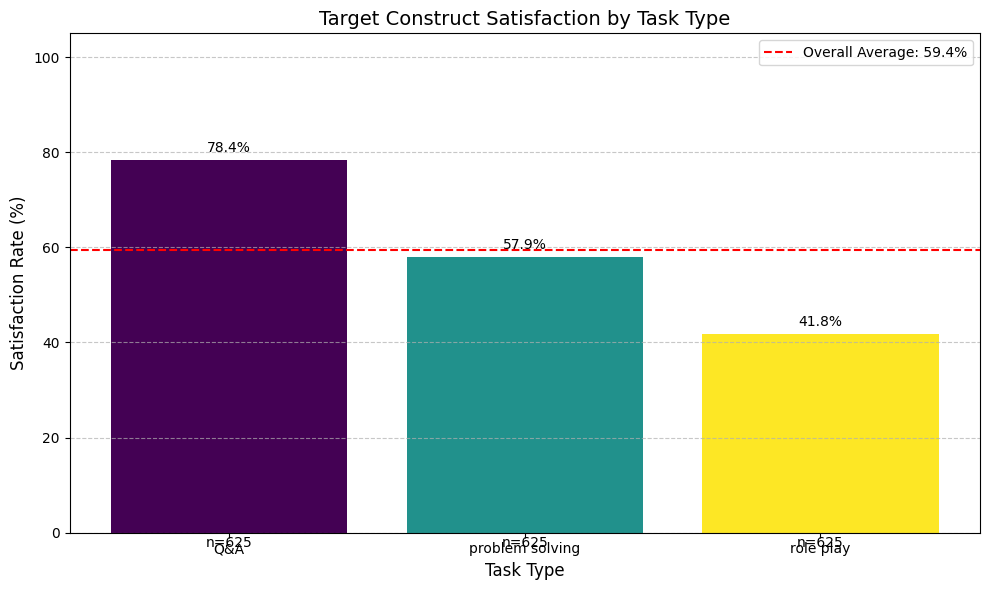

In [ ]:
def create_target_construct_by_task_type_graph(results_df, output_file='target_construct_by_task_type.png'):
    # Group by task_type and calculate satisfaction rate
    task_type_satisfaction = results_df.groupby(['task_type']).agg({
        'has_target_construct': ['mean', 'count']
    })

    # Flatten the multi-index columns
    task_type_satisfaction.columns = ['satisfaction_rate', 'count']
    task_type_satisfaction['satisfaction_percentage'] = task_type_satisfaction['satisfaction_rate'] * 100

    # Sort for better visualization
    task_type_satisfaction = task_type_satisfaction.sort_values('satisfaction_percentage', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        task_type_satisfaction.index,
        task_type_satisfaction['satisfaction_percentage'],
        color=plt.cm.viridis(np.linspace(0, 1, len(task_type_satisfaction)))
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom'
        )

    # Add count labels beneath x-axis
    for i, (task_type, row) in enumerate(task_type_satisfaction.iterrows()):
        plt.text(
            i,
            -3,
            f'n={int(row["count"])}',
            ha='center'
        )

    # Add overall average line
    overall_avg = results_df['has_target_construct'].mean() * 100
    plt.axhline(y=overall_avg, color='red', linestyle='--',
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.title('Target Construct Satisfaction by Task Type', fontsize=14)
    plt.xlabel('Task Type', fontsize=12)
    plt.ylabel('Satisfaction Rate (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    return task_type_satisfaction

task_type_data = create_target_construct_by_task_type_graph(analysis_df)

<Figure size 2200x1200 with 0 Axes>

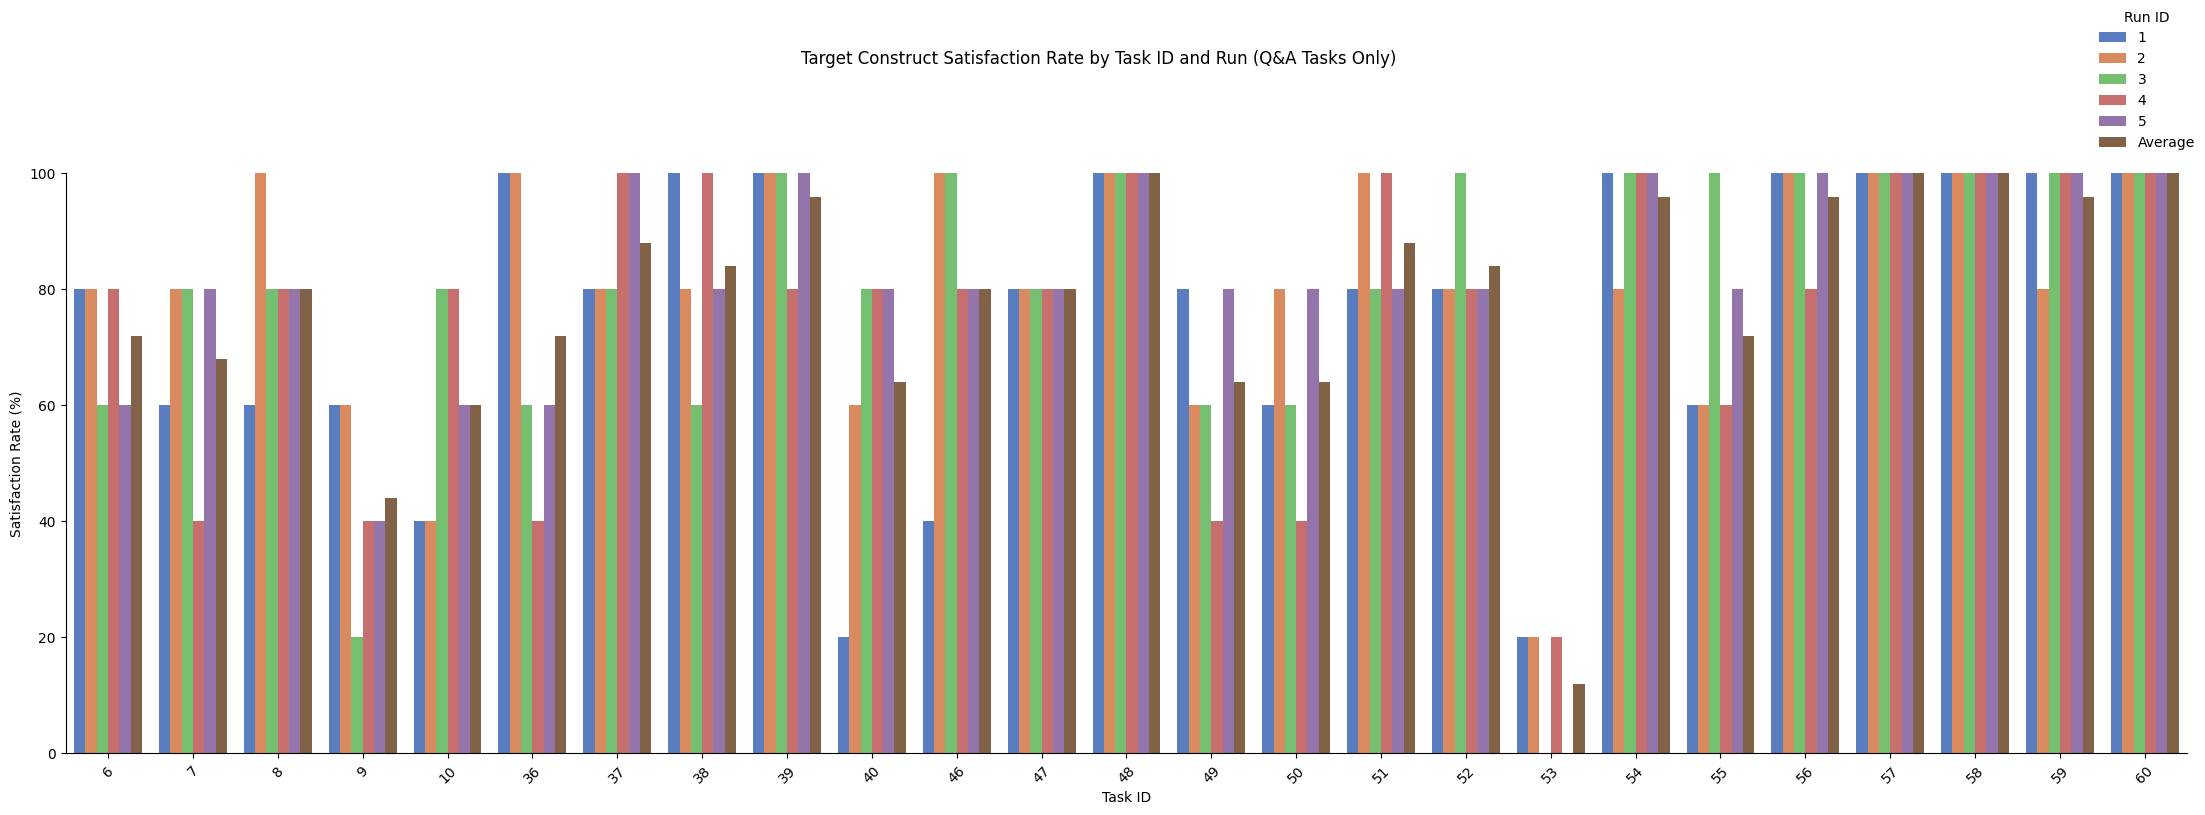

In [ ]:
# First, filter for only Q&A tasks
qa_tasks = analysis_df[analysis_df['task_type'] == 'Q&A'].copy()

# Convert the string 'True'/'False' to actual boolean values
qa_tasks['has_target_construct'] = qa_tasks['has_target_construct'].astype(str).str.lower() == 'true'

# Calculate satisfaction rate for each task and run, using the correct denominator of 5 rows per run
run_satisfaction = (
    qa_tasks.groupby(['task_id', 'run_id'])['has_target_construct']
    .sum() / 5 * 100  # Correct denominator is 5, not 25
)
run_satisfaction = run_satisfaction.reset_index()

# Get the task averages (average across all runs for each task)
task_avg = (
    qa_tasks.groupby(['task_id'])['has_target_construct']
    .mean() * 100
)
task_avg = task_avg.reset_index()
task_avg['run_id'] = 'Average'

# Combine the run data with the average data
combined_data = pd.concat([run_satisfaction, task_avg])

# Create the grouped bar chart
plt.figure(figsize=(22, 12))
g = sns.catplot(
    data=combined_data,
    kind="bar",
    x="task_id",
    y="has_target_construct",
    hue="run_id",
    palette="muted",
    height=7,
    aspect=3
)

g.set_axis_labels("Task ID", "Satisfaction Rate (%)")
g.legend.set_title("Run ID")
g.fig.suptitle('Target Construct Satisfaction Rate by Task ID and Run (Q&A Tasks Only)', y=1.1)
g.legend.set_bbox_to_anchor((1.0, 1.05))
g.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_construct_satisfaction_qa_by_task_run.png', dpi=300)
plt.show()